# 02 - Data from the Web

## Deadline
Wednesday October 25, 2017 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated (i.e., you don't want your colleagues to generate unnecessary Web traffic during the peer review)
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code.

## Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so you will have to find a way to scrape the information we need!
You are not allowed to download manually the entire ranking -- rather you have to understand how the server loads it in your browser. For this task, Postman with the Interceptor extension can help you greatly. We recommend that you watch this [brief tutorial](https://www.youtube.com/watch?v=jBjXVrS8nXs&list=PLM-7VG-sgbtD8qBnGeQM5nvlpqB_ktaLZ&autoplay=1) to understand quickly how to use it.

## Assignment
1. Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the [details page](https://www.topuniversities.com/universities/ecole-polytechnique-fédérale-de-lausanne-epfl).
Store the resulting dataset in a pandas DataFrame and answer the following questions:
  * Which are the best universities in term of: (a) ratio between faculty members and students, (b) ratio of international students?
  * Answer the previous question aggregating the data by (c) country and (d) region.
  Plot your data using bar charts and describe briefly what you observed.

2. Obtain the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Repeat the analysis of the previous point and discuss briefly what you observed.

3. Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

4. Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

5. Can you find the best university taking in consideration both rankings? Explain your approach.

Hints:
- Keep your Notebook clean and don't print the verbose output of the requests if this does not add useful information for the reader.
- In case of tie, use the order defined in the webpage.

## Solution

### Task 1 - *Top Universities* rankings

Before the beginning of the analysis it is necessary to import all of the libraries that will be used in the later steps and set the default styling of all the plots.

In [1]:
%pylab inline
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import difflib
import re
pd.options.mode.chained_assignment = None
sns.set_context('notebook')
sns.set(style='darkgrid')
color_scheme = ["#F94867", "#70E041", "#FFD84B", "#5448BB", "#FF7089", "#9AFE70", "#FFE071", "#9083FD"]
sns.set_palette(sns.color_palette(color_scheme))
plt.rcParams['axes.labelsize'] = 18
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

Populating the interactive namespace from numpy and matplotlib


By using Postman Interceptor we observed that if we generated a HTTP get request for the [Top Universities 2018 rankings](https://www.topuniversities.com/university-rankings/world-university-rankings/2018), in the response we would not get the information about ranked universities but instead a html page and a separate *.txt* file that contains all of the basic university information and rankings.
The mentioned *.txt* file stores the data in *json* format which enabled us to save it in a Python dictionary variable without any prior reformatting.

By studying the file more closely we realised that for each university, among others, it containes information about: 
 - **country** - the country of origin of the university,
 - **guide** - the URL that leads to the page with guide for best universities of the country of origin,
 - **logo** - the link to the image of university logo,
 - **nid** - the unique ID of the university on the website,
 - **rank_display** - the current ranking on the list of top universities,
 - **region** - the region in which the country of origin is located,
 - **score** - the final score used for ranking, with respect to the factors like: academic reputation, citations per faculty, employer reputation, number of students, number of internatonal students etc,
 - **stars** - the QS star result which ranges from 0 to 5+ stars, depending on the number of points achieved through the evaluation of over at least 8 categories,
 - **title** - the official name of the university,
 - **url** - the URL that leads to the page of the particular university, and provides additional details about it.

One of the key attributes of universities is the *url*, which enabled us to extract more detailed data necessary for performing the thorough analysis of the universities and the origin and number of their faculty members and students.

In [2]:
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt')
topuni_dict = r.json()
topuni_dict['data'][0]

{'cc': 'US',
 'core_id': '410',
 'country': 'United States',
 'guide': '<a href="/where-to-study/north-america/united-states/guide" class="guide-link" target="_blank">United States</a>',
 'logo': '<img src="https://www.topuniversities.com/sites/default/files/massachusetts-institute-of-technology-mit_410_small_0.jpg" alt="Massachusetts Institute of Technology (MIT)  Logo">',
 'nid': '294850',
 'rank_display': '1',
 'region': 'North America',
 'score': '100',
 'stars': '6',
 'title': 'Massachusetts Institute of Technology (MIT)',
 'url': '/universities/massachusetts-institute-technology-mit'}

We defined the function *get_count()* with parameters *html* (that represents the parsed html page) and *html_class* (the name of the html class/div we are looking for) in order to return the character sequence that coresponds to requested class name. Unfortunately some html pages have different formats and some of the classes are missing, so it was necessary to check if the class name was found in the html page in the first place. Afterwards, we tried to extract the *number* class from the found class/div and reformat it in order to prepare it for its later transformation to number type.
If any of the searched classes do not exist by the name they are searched for or don't have the number value, the function returns a NaN value.

We also created a function *get_stats()* that returns additional data about the universities (size of the university, it's age and it's status - public or private) that will be used later in exploratory analysis. For each university, we had to send yet another HTTP request that obtains additional information by using it's *nid* and parse a *json* file to obtain the required data.

In [3]:
def get_count(html, html_class):
    outer_class = html.find(class_= html_class)
    if outer_class:
        inner_class = outer_class.find(class_='number')       
        if inner_class:
            return inner_class.text.strip().replace(',', '')
    return np.nan

def get_stats(uni_id):    
    if uni_id is not np.nan:
        r = requests.get('https://www.topuniversities.com/qs-profiles/classifications/' + uni_id)
        stats_dict = r.json()['classifications']
        return stats_dict['size_value'] if 'size_value' in stats_dict else np.nan,\
               stats_dict['age_value'] if 'age_value' in stats_dict else np.nan,\
               ('public' if stats_dict['data_status_value'] is 'A' else 'private') if 'data_status_value' in stats_dict else np.nan
    return np.nan, np.nan, np.nan

The function *extract_information()* extracts the data from the URL that contains detailed information about a specific university and parses it to a string using BeautifulSoup html parser. Afterwards, for each row of the extracted DataFrame the *get_count()* function is called in order to retrieve the data about number of total and international faculty members and students, and *get_stats()* is called to retrieve the data about the university's size, age and status.

In [4]:
def extract_information(row):
    r = requests.get('https://www.topuniversities.com/' + row['url'])    
    soup = BeautifulSoup(r.text, 'html.parser')    
    row['total faculty members'] = get_count(html = soup, html_class = 'total faculty')
    row['international faculty members'] = get_count(html = soup, html_class = 'inter faculty')
    row['total students'] = get_count(html = soup, html_class = 'total student')
    row['international students'] = get_count(html = soup, html_class = 'total inter')
    
    #pretvori age u broj i size u kategoriju ili oba
    row['size'], row['age'], row['status'] = get_stats(uni_id = row['nid'])
    return row    

We loaded the dictionary that was created in the first step and collected the *data* element which holds information about the universities in the [Top Universities world rankings](https://www.topuniversities.com/university-rankings/world-university-rankings/2018) and their rankings. We were able to collect just the first 200 universities of the file without any conditions, because they are already sorted by rank in the file. After that, we dropped all of the columns with the data that was currently irrelevant and added the empty columns in which we later inserted tha data using the function *extract_information()* on each row of the DataFrame.

In [5]:
topuni_ranking = pd.DataFrame().from_dict(topuni_dict['data'][:200])
topuni_ranking.drop(['core_id', 'cc', 'guide', 'logo', 'stars', 'score'], axis = 1, inplace = True)
topuni_ranking.set_index('title', inplace = True)
topuni_ranking = pd.concat([topuni_ranking, pd.DataFrame(columns = ['total faculty members', 'international faculty members', 'total students', 'international students', 'size', 'age', 'status'])])
topuni_ranking.apply(extract_information, axis = 1)

,age,country,international faculty members,international students,nid,rank_display,region,size,status,total faculty members,total students,url
Massachusetts Institute of Technology (MIT),5,United States,1679,3717,294850,1,North America,M,private,2982,11067,/universities/massachusetts-institute-technolo...
Stanford University,5,United States,2042,3611,297282,2,North America,L,private,4285,15878,/universities/stanford-university
Harvard University,5,United States,1311,5266,294270,3,North America,L,private,4350,22429,/universities/harvard-university
California Institute of Technology (Caltech),5,United States,350,647,294562,4,North America,S,private,953,2255,/universities/california-institute-technology-...
University of Cambridge,5,United Kingdom,2278,6699,294561,5,Europe,L,public,5490,18770,/universities/university-cambridge
University of Oxford,5,United Kingdom,2964,7353,294654,6,Europe,L,public,6750,19720,/universities/university-oxford
UCL (University College London),5,United Kingdom,2554,14854,294014,7,Europe,XL,public,6345,31080,/universities/ucl-university-college-london
Imperial College London,5,United Kingdom,2071,8746,294030,8,Europe,L,public,3930,16090,/universities/imperial-college-london
University of Chicago,5,United States,635,3379,294536,9,North America,L,private,2449,13557,/universities/university-chicago
ETH Zurich - Swiss Federal Institute of Technology,5,Switzerland,1886,7563,294432,10,Europe,L,public,2477,19815,/universities/eth-zurich-swiss-federal-institu...


In this step we transformed the values in columns *total faculty members*, *international faculty members*, *total students*, *international students* to numeric values, because we wanted to use them for specific numerical operations in later phases. Because we already inserted all of the needed information from details section of each university, we dropped the columns *url*and *nid*.

In [6]:
topuni_ranking.drop(['url', 'nid'], axis = 1, inplace = True)
topuni_ranking.rename(columns = {'rank_display':'rank'}, inplace = True)
topuni_ranking[['total faculty members', 'international faculty members','total students', 'international students']] = topuni_ranking[['total faculty members', 'international faculty members','total students', 'international students']].apply(pd.to_numeric)

Next, we decided to fill some of the missing data. First we looked at the values that are used to classify the universities by size.

In [7]:
#print sizes
topuni_ranking['size'].unique()

array(['M', 'L', 'S', 'XL'], dtype=object)

There were no NaN values in the *size* column, so we used the above values to create a ordered category in the *size* column.
The sizes are:
 * S --  universities with less than 5000 students,
 * M -- universities with more than 5000 students, but less than 12 000,
 * L -- universities with more than 12 000 students, but less than 30 000,
 * XL -- universities with more than 30 000 students.
 
S is the smallest size, and XL is the largest.

In [8]:
sizes = ['S', 'M', 'L', 'XL']
topuni_ranking['size'] = topuni_ranking['size'].astype("category", categories=sizes, ordered=True)

Then we looked at the values that are used to classify the universities by age.

In [9]:
topuni_ranking['age'].unique()  #see all values, see that there are nulls, values are not intuitive, will be mapped

array(['5', '3', '4', '2', '1', nan], dtype=object)

Here we saw that there are some rows that have a NaN value in the *age* column.
The other values in the *age* column have these meanings:
 * 1 -- universities founded less than 10 years ago,
 * 2 -- universities founded more than 10, but less than 25 years ago,
 * 3 -- universities founded more than 25, but less than 50 years ago,
 * 4 -- universities founded more than 50, but less than 100 years ago,
 * 5 -- universities founded more than 100 years ago.

We tried to locate all the rows without an *age* value.

In [10]:
topuni_ranking[topuni_ranking['age'].isnull()]

,age,country,international faculty members,international students,rank,region,size,status,total faculty members,total students
Scuola Normale Superiore di Pisa,NaN,Italy,1.0,48.0,=192,Europe,S,NaN,86.0,532.0


To fix this we consuted the website of the university with no age.
The *Scuola Normale Superiore di Pisa* was founded on [18th of October 1810](https://en.sns.it/about-sns/history) therefore it is older than 100 years old, so we assigned the value 5 to its age column. Then we replaced the values in the age column with descriptions that have more meaning, and make reading the DataFrame a lot easier. Afterwards, using the descriptive values, we made the *age* column ordered and categorical.

In [11]:
topuni_ranking.loc['Scuola Normale Superiore di Pisa', 'age'] = '5'
#replacing values with descriptions
ages = ["<10", ">10 and 25<", ">25 and <50", ">50 and <100", ">100"]
topuni_ranking.replace(to_replace={'age': {'1': '<10', '2': '>10 and 25<', '3': '>25 and <50', '4': '>50 and <100', '5': '>100'}}, inplace=True)
topuni_ranking['age'] = topuni_ranking['age'].astype("category", categories=ages, ordered=True)

After this, we looked at the values that are used to classify the universities by status.
The values found in this column are *public* and *private*.
A public university is a university that is predominantly funded by public means through a national or subnational government, as opposed to private universities ([Source](http://www.definitions.net/definition/Public%20University)).
We found some rows with a NaN value in the *status* column.

In [12]:
#find if there is a nan value
topuni_ranking[topuni_ranking['status'].isnull()]

,age,country,international faculty members,international students,rank,region,size,status,total faculty members,total students
Scuola Normale Superiore di Pisa,>100,Italy,1.0,48.0,=192,Europe,S,NaN,86.0,532.0
Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento,>25 and <50,Italy,1.0,135.0,=192,Europe,S,NaN,119.0,789.0


To fix this we consuted the websites of the universities with missing status.
The *Scuola Normale Superiore di Pisa* is a [public](https://en.sns.it/) university. 
The *Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento* is also a [public](https://www.santannapisa.it/en/university/the-school) university. 
Then we set the *status* column to public for both of these rows.
Afterwards, we made the *status* column categorical, but unordered.

In [13]:
topuni_ranking.loc['Scuola Normale Superiore di Pisa', 'status'] = 'public'
topuni_ranking.loc['Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento', 'status'] = 'public'
statuses = ['private', 'public']
topuni_ranking['status'] = topuni_ranking['status'].astype("category", categories=statuses, ordered=False)

Finally, we checked the data types of the columns in the *topuni_ranking* DataFrame.

In [14]:
topuni_ranking.dtypes

age                              category
country                            object
international faculty members     float64
international students            float64
rank                               object
region                             object
size                             category
status                           category
total faculty members             float64
total students                    float64
dtype: object

After the initial basic transformations of the *Top Universities* DataFrame we serialized it to a pickle file because we didn't want to send more than 400 HTTP GET requests each time we run this notebook.

In [15]:
topuni_ranking.to_pickle('topuni_ranking.pkl')

The first execution of this notebook will generate the *topuni_ranking.pkl* file which contains the rankings of the 200 best universities according to *Top Universities*. Each later execution can start from this point, thereby avoiding the sending of multiple HTTP requests.

In [16]:
topuni_ranking = pd.read_pickle('topuni_ranking.pkl')

<a id="ratio"></a>
The function *student_staff_ratio()* is used to divide the total number of students with the total number of currenly employed faculty members for the given row.

We used the ratios we gained by using this function to sort the universities in the DataFrame from the one with the best to the one with the worst ratio. The university with the smallest number of students per professor is considered to be the best one, because we concluded that this would enable the best learning and teaching conditions.

In [17]:
#find ratio between students and faculty members
def student_staff_ratio(row):
    return row['total students']/row['total faculty members']
#order by ratio between students and faculty members
topuni_ranking['student to staff ratio'] = round(topuni_ranking.apply(student_staff_ratio, axis = 1), 1)
topuni_ranking.sort_values('student to staff ratio')

,age,country,international faculty members,international students,rank,region,size,status,total faculty members,total students,student to staff ratio
California Institute of Technology (Caltech),>100,United States,350.0,647.0,4,North America,S,private,953.0,2255.0,2.4
Yale University,>100,United States,1708.0,2469.0,16,North America,L,private,4940.0,12402.0,2.5
University of Oxford,>100,United Kingdom,2964.0,7353.0,6,Europe,L,public,6750.0,19720.0,2.9
University of Cambridge,>100,United Kingdom,2278.0,6699.0,5,Europe,L,public,5490.0,18770.0,3.4
Johns Hopkins University,>100,United States,1061.0,4105.0,17,North America,L,private,4462.0,16146.0,3.6
Massachusetts Institute of Technology (MIT),>100,United States,1679.0,3717.0,1,North America,M,private,2982.0,11067.0,3.7
Stanford University,>100,United States,2042.0,3611.0,2,North America,L,private,4285.0,15878.0,3.7
University of Rochester,>100,United States,488.0,2805.0,186,North America,M,private,2569.0,9636.0,3.8
University of Pennsylvania,>100,United States,1383.0,4250.0,19,North America,L,private,5499.0,20639.0,3.8
Columbia University,>100,United States,913.0,8105.0,18,North America,L,private,6189.0,25045.0,4.0


The best university according to the *Top Universities* rankings and the ratio between the students and faculty members is the *California Institute of Technology (Caltech)* with the ratio of only 2.4 students per faculty member.

The function *inter_student_ratio()* is used to divide the total number of international students with the total number of students from the country of origin (calculated by subtracting the total number of international students from the total number of all students). We decided to use this formula, because we consider it gives the real ratio, and the formula that uses only the total number of all students as the denominator would give us the percentange of international students and not the required ratio.

Afterwards, we used the ratios we gained by using this function to sort the universities in the DataFrame from the one with biggest number of international students per national students, to the one with the worst. We considered one of the most important benefits of international students is the way they diversify the campus. Home students get a broader experience of life by learning alongside students from every corner of the globe. ([Source]( https://www.theguardian.com/education/mortarboard/2012/sep/10/benefits-of-studying-with-international-students))

In [18]:
#find ratio of international students
def inter_student_ratio(row):
    return row['international students']/(row['total students'] - row['international students'])

#order by ratio of international students
topuni_ranking['international students ratio'] = round (topuni_ranking.apply(inter_student_ratio, axis = 1), 1)
topuni_ranking.sort_values('international students ratio', ascending = False)

,age,country,international faculty members,international students,rank,region,size,status,total faculty members,total students,student to staff ratio,international students ratio
London School of Economics and Political Science (LSE),>100,United Kingdom,687.0,6748.0,35,Europe,M,public,1088.0,9760.0,9.0,2.2
Ecole Polytechnique Fédérale de Lausanne (EPFL),>100,Switzerland,1300.0,5896.0,12,Europe,M,public,1695.0,10343.0,6.1,1.3
Imperial College London,>100,United Kingdom,2071.0,8746.0,8,Europe,L,public,3930.0,16090.0,4.1,1.2
Maastricht University,>25 and <50,Netherlands,502.0,8234.0,200,Europe,L,public,1277.0,16385.0,12.8,1.0
Carnegie Mellon University,>100,United States,425.0,6385.0,=47,North America,L,private,1342.0,13356.0,10.0,0.9
UCL (University College London),>100,United Kingdom,2554.0,14854.0,7,Europe,XL,public,6345.0,31080.0,4.9,0.9
University of St Andrews,>100,United Kingdom,485.0,4030.0,92,Europe,M,public,1140.0,8800.0,7.7,0.8
Queen Mary University of London,>100,United Kingdom,801.0,6806.0,127,Europe,L,public,1885.0,16135.0,8.6,0.7
King's College London,>100,United Kingdom,1513.0,9451.0,=23,Europe,L,public,3650.0,23780.0,6.5,0.7
The University of Hong Kong,>100,Hong Kong,2085.0,8230.0,26,Asia,L,public,3012.0,20214.0,6.7,0.7


The best university according to the *Top Universities* rankings and the ratio between the international students and national students is the *London School of Economics and Political Science (LSE)* with the ratio of 2.2 international students per national student.

The next few cells explain why we chose not to transform the country and region columns into the categorial data type. We created a copy of the *topuni_ranking* DataFrame. Then we set the country and region columns to categorical data types in the copied version.

In [19]:
categorical_test = topuni_ranking.copy()
categorical_test['country'] = categorical_test['country'].astype('category')
categorical_test['region'] = categorical_test['region'].astype('category')

We timed the speed of grouping by the *country* column, summing the values and sorting the *student to staff ratio values* when using the original and modified DataFrames.

In [20]:
%timeit topuni_ranking.groupby('country').sum().sort_values('student to staff ratio')

100 loops, best of 3: 1.91 ms per loop


In [21]:
%timeit categorical_test.groupby('country').sum().sort_values('student to staff ratio')

100 loops, best of 3: 2.26 ms per loop


As shown above, transforming the country column to a category only slows down operations that work with this column. The exact time values vary from computer to computer, but the second one was slower in all of our tests.

Then we timed the speed of grouping by the *region* column, summing the values and sorting the *student to staff ratio values* when using the original and modified DataFrames.

In [22]:
%timeit topuni_ranking.groupby('region').sum().sort_values('student to staff ratio')

100 loops, best of 3: 1.83 ms per loop


In [23]:
%timeit categorical_test.groupby('region').sum().sort_values('student to staff ratio')

100 loops, best of 3: 2.39 ms per loop


Transforming the region column to a category again slows down operations that work with it. Because of these timings we chose not to make these columns into categories.

We created a helper function *plot_barchart()* to help us plot bar charts. It creates a bar chart (*barplot*) at the desired *grid_position*. The bar chart is made by taking the DataFrame *df*, and grouping by the *groupby_col* and summing the other columns. Then a new column is added, called *new_col* which is filled with values that are made by applying the *groupby_func* to the DataFrame. The values in the *new_col* are then sorted using the *ascending* parameter, and plotted. The subplot title is set with the *title* parameter.

In [24]:
def plot_barchart(df, new_col, groupby_col, groupby_func, ascending, grid_position, title):
    plt.subplot(grid_position)
    kwargs = {new_col : df.groupby(groupby_col).sum().apply(groupby_func, axis = 1)}
    chart = df.groupby(groupby_col).sum().assign(**kwargs).sort_values(new_col, ascending = ascending)
    sns.barplot(x = chart.index, y = chart[new_col]).set_xticklabels(chart.index, rotation=90, fontsize = 14)
    plt.title(title, fontsize = 18)    

We decided not to sort countries by the average ratio of all the universities in selected country, because we think it doesn't represent the real indicator of the actual number of students per faculty member in the country. The problem is that some of the smaller universities create big divergence from other average values which leads to the reducement of the ratio, even though this is not a country-wise phenomenon.

Instead, we used a formula that divides the total number of students of the universities in the mentioned country with the total number of faculty members in the mentioned country. The ratio calculated this way should give us a better perception of an overall number of students per one faculty member in that country. This is accomplished using the *plot_barchart()* function.

The similar procedure was applied to different regions, and to the ratio of international per national students in different countries and regions.

We created two plots because we wanted to visualise the ratio between students and faculty members and the differences that exist between ratio in different countries and regions. As we mentioned when we calculated [the ratio](#ratio), the fact that the ratio is lower is actually positive because students can get more individual attention from the professor/teaching assistant. ([Source](http://www.methodschools.org/blog/what-are-the-advantages-to-schools-with-small-class-sizes-0))

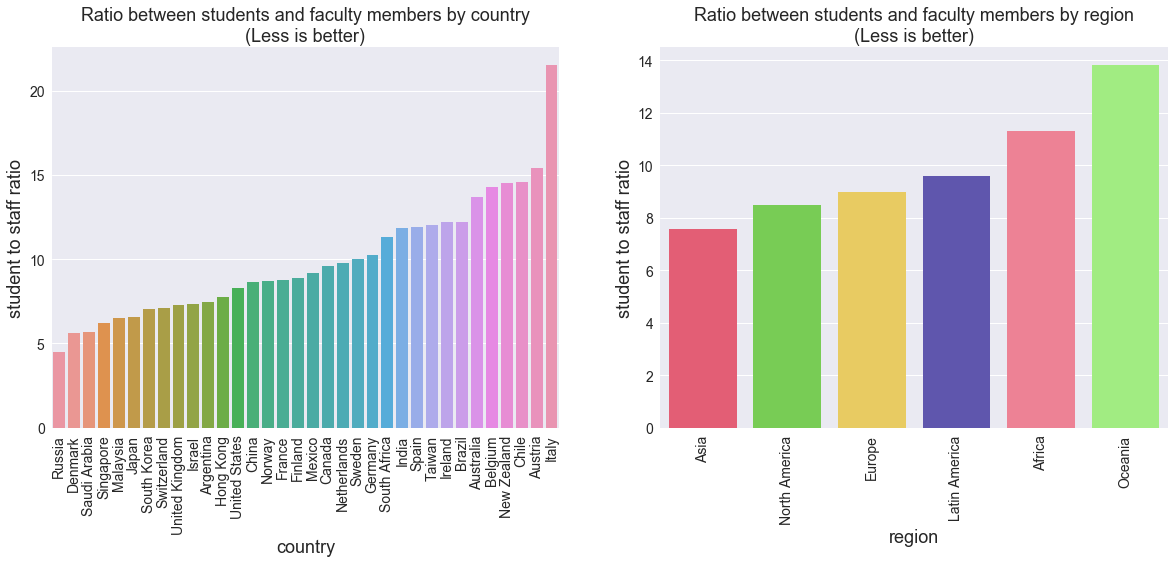

In [25]:
plt.figure(figsize = (20, 7))
grid  = GridSpec(1, 2)
#order by ratio between students and faculty members by country
plot_barchart(topuni_ranking, 'student to staff ratio', 'country', student_staff_ratio, True, grid[0, 0], 'Ratio between students and faculty members by country\n(Less is better)')
#order by ratio between students and faculty members by region
plot_barchart(topuni_ranking, 'student to staff ratio', 'region', student_staff_ratio, True, grid[0, 1], 'Ratio between students and faculty members by region\n(Less is better)')

The chart shows that universities in Italy create a significant outlier with over 20 students per professor, while all of the other countries have 15 and less students per professor, with Russia having the best staff to student ratio that is equal to less than 5 students per professor. Asia is the region with the smallest ratio, while Oceania has the biggest staff to student ratio.

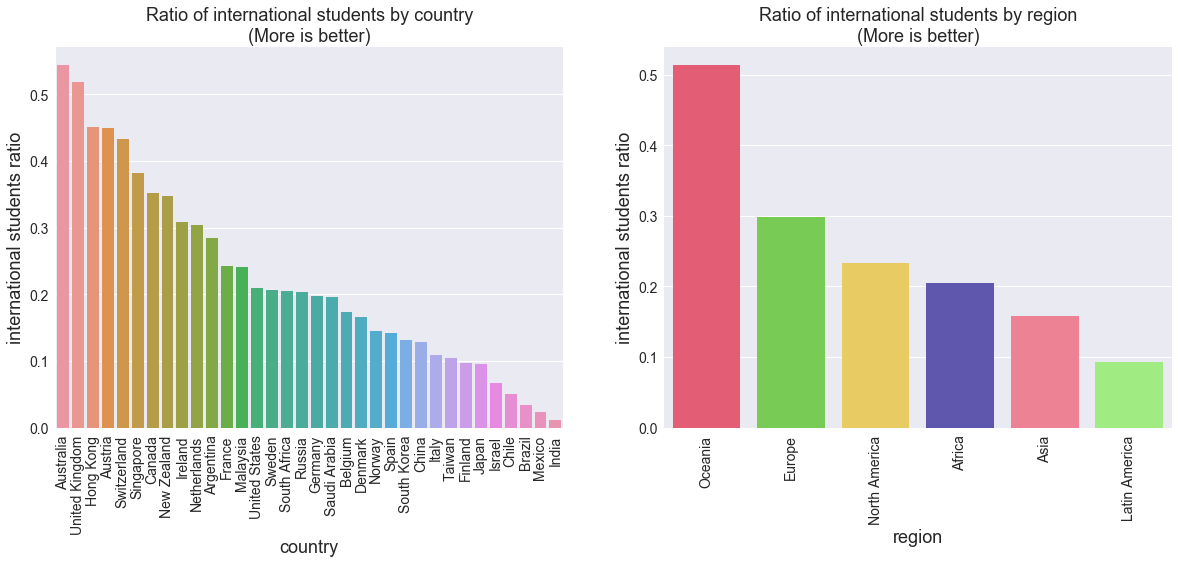

In [26]:
plt.figure(figsize = (20, 7))
grid = GridSpec(1, 2)
#order by ratio of international students by country
plot_barchart(topuni_ranking, 'international students ratio', 'country', inter_student_ratio, False, grid[0, 0], 'Ratio of international students by country\n(More is better)')
#order by ratio of international students by region
plot_barchart(topuni_ranking, 'international students ratio', 'region', inter_student_ratio, False, grid[0, 1], 'Ratio of international students by region\n(More is better)')

Afterwards, we plotted the graphs for the ratio of international students by country and region. The Oceania and Australia are region and country with the largest number of international per national students with ratio of over 0.5 (around 1 international per 2 national students).

### Task 2 - *Times Higher Education* rankings

We repeated the similar process for retrieving the information about the universities with [Times Higher Education 2018 rankings](http://timeshighereducation.com/world-university-rankings/2018/world-ranking).

The first difference we encountered between two lists was in the json file, and it concerned the attributes and information that is stored about each univeristy. By studying the file more closely we realised that for each university, among others, it contains information about: 
 - **aliases** - the official and alternative names of the university,
 - **location** - the country of origin of the university,
 - **name** - the official name of the university,
 - **rank** - the current ranking on the list of top universities,
 - **scores_citations** - the score of the university calculated with respect to the research influence,
 - **scores_citations_rank** - the rank of the university based on the scores_citations attribute,
 - **scores_industry_income** - the score of the university calculated with respect to the knowledge transfer,
 - **scores_industry_income_rank** - the rank of the university based on the scores_industry_income attribute,
 - **scores_international_outlook** - the score of the university calculated with respect to number of international staff members, students and researchers,
 - **scores_international_outlook_rank** - the rank of the university based on the scores_international_outlook attribute,
 - **scores_overall** - the final score used for ranking the university with respect to all of the other mentioned factors,
 - **scores_overall_rank** - the rank of the university based on the final score stored in the scores_overall attribute,
 - **scores_research** - the score of the university calculated with respect to the volume, income and reputation of the research papers of the university,
 - **scores_research_rank** - the rank of the university based on the scores_research attribute,
 - **scores_teaching** - the score of the university calculated with respect to the learning environment,
 - **scores_teaching_rank** - the rank of the university based on the scores_teaching attribute,
 - **stats_female_male_ratio** - the ratio of female to male students at the university,
 - **stats_number_students** - the number of full-time equivalent students at the university,
 - **stats_pc_intl_students** - the percentage of students originating from outside the country of the university,
 - **stats_student_staff_ratio** - the ratio of full-time equivalent students to the number of academic staff,
 - **subjects_offered** - list of the subjects that are taught at the university,
 - **url** - the URL that leads to the page of the particular university, and provides additional details about it.


This meant that we have all the needed information in this *json* file and that we don't need to go to the page of the specific university and extract data from there.

In [27]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
times_dict = r.json()
times_dict['data'][0]

{'aliases': 'University of Oxford',
 'location': 'United Kingdom',
 'member_level': '0',
 'name': 'University of Oxford',
 'nid': 468,
 'rank': '1',
 'rank_order': '10',
 'record_type': 'master_account',
 'scores_citations': '99.1',
 'scores_citations_rank': '15',
 'scores_industry_income': '63.7',
 'scores_industry_income_rank': '169',
 'scores_international_outlook': '95.0',
 'scores_international_outlook_rank': '24',
 'scores_overall': '94.3',
 'scores_overall_rank': '10',
 'scores_research': '99.5',
 'scores_research_rank': '1',
 'scores_teaching': '86.7',
 'scores_teaching_rank': '5',
 'stats_female_male_ratio': '46 : 54',
 'stats_number_students': '20,409',
 'stats_pc_intl_students': '38%',
 'stats_student_staff_ratio': '11.2',
 'subjects_offered': 'Archaeology,Art, Performing Arts & Design,Biological Sciences,Business & Management,Chemical Engineering,Chemistry,Civil Engineering,Computer Science,Economics & Econometrics,Electrical & Electronic Engineering,General Engineering,Geo

We created two functions to help us calculate the ratios. The first function *get_num_of_int_students()* is used to calculate the product of the attributes *stats_pc_intl_students* and *stats_number_students* in order to get the total number of international students. The function *get_num_of_total_staff()* is used for calculating the number of total faculty members by dividing the attribute *stats_number_students* with the *stats_student_staff_ratio*. Both results are rounded to one decimal place and inserted in the corresponding columns, for each row that is forwarded to the function.

In [28]:
def get_num_of_int_students(row):
    row['stats_pc_intl_students'] = round(row['stats_pc_intl_students']*row['stats_number_students'], 1)
    return row

def get_num_of_total_staff(row):
    row['total faculty members'] = round(row['stats_number_students']/row['stats_student_staff_ratio'], 1)
    return row

The last three imported universities have the same rank of 198, because they had the same scoring result. We checked to see if the 201st university (and maybe even more of the following ones) has the same score, because if it did we would have to import it too, or otherwise the evaluation would be flawed. This year the list has only those three universities with the rank 198, so this time no additional importing is necessary.

Additionaly, we set the index of the DataFrame that contains *Times* rankings to the *name* column, and dropped the columns we are not using in our current analysis.

In [29]:
times_ranking = pd.DataFrame().from_dict(times_dict['data'][:200])
times_ranking.set_index('name', inplace = True)
times_ranking.drop(['member_level', 'nid', 'rank_order', 'record_type', 'scores_citations', 'scores_citations_rank', 'scores_industry_income', 'scores_industry_income_rank', 'scores_international_outlook', 'scores_international_outlook_rank', 'scores_overall', 'scores_overall_rank', 'scores_research', 'scores_research_rank', 'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio', 'subjects_offered', 'url'], axis = 1, inplace = True)
times_ranking

,aliases,location,rank,stats_number_students,stats_pc_intl_students,stats_student_staff_ratio
name,,,,,,
University of Oxford,University of Oxford,United Kingdom,1,"20,409",38%,11.2
University of Cambridge,University of Cambridge,United Kingdom,2,"18,389",35%,10.9
California Institute of Technology,California Institute of Technology caltech,United States,=3,"2,209",27%,6.5
Stanford University,Stanford University,United States,=3,"15,845",22%,7.5
Massachusetts Institute of Technology,Massachusetts Institute of Technology,United States,5,"11,177",34%,8.7
Harvard University,Harvard University,United States,6,"20,326",26%,8.9
Princeton University,Princeton University,United States,7,"7,955",24%,8.3
Imperial College London,Imperial College London,United Kingdom,8,"15,857",55%,11.4
University of Chicago,University of Chicago,United States,9,"13,525",25%,6.2


We transformed the data in the columns *stats_number_students*, *stats_pc_intl_students* and *stats_student_staff_ratio* to numbers. We also applied the previously explained functions *get_num_of_int_students()* and *get_num_of_total_staff()* to each row of the DataFrame in order to later get similar information about ratios to the ones we have in the *Top Universities* rankings and renamed the columns to match the names we gave in the first DataFrame.

In [30]:
times_ranking['stats_number_students'] = times_ranking['stats_number_students'].apply(lambda x: x.strip().replace(',', ''))
times_ranking['stats_pc_intl_students'] = times_ranking['stats_pc_intl_students'].apply(lambda x: float(x.strip('%'))/100)
times_ranking[['stats_number_students', 'stats_pc_intl_students','stats_student_staff_ratio']] = times_ranking[['stats_number_students', 'stats_pc_intl_students','stats_student_staff_ratio']].apply(pd.to_numeric)

times_ranking = times_ranking.apply(get_num_of_int_students, axis = 1)
times_ranking = times_ranking.apply(get_num_of_total_staff, axis = 1)

times_ranking.rename(columns = {'location':'country', 'stats_number_students':'total students', 'stats_pc_intl_students':'international students', 'stats_student_staff_ratio': 'student to staff ratio'}, inplace = True)

times_ranking

,aliases,country,rank,total students,international students,student to staff ratio,total faculty members
name,,,,,,,
University of Oxford,University of Oxford,United Kingdom,1,20409,7755.4,11.2,1822.2
University of Cambridge,University of Cambridge,United Kingdom,2,18389,6436.1,10.9,1687.1
California Institute of Technology,California Institute of Technology caltech,United States,=3,2209,596.4,6.5,339.8
Stanford University,Stanford University,United States,=3,15845,3485.9,7.5,2112.7
Massachusetts Institute of Technology,Massachusetts Institute of Technology,United States,5,11177,3800.2,8.7,1284.7
Harvard University,Harvard University,United States,6,20326,5284.8,8.9,2283.8
Princeton University,Princeton University,United States,7,7955,1909.2,8.3,958.4
Imperial College London,Imperial College London,United Kingdom,8,15857,8721.4,11.4,1391.0
University of Chicago,University of Chicago,United States,9,13525,3381.2,6.2,2181.5


Finally, we checked the data types of the columns in the *times_ranking* DataFrame.

In [31]:
times_ranking.dtypes

aliases                    object
country                    object
rank                       object
total students              int64
international students    float64
student to staff ratio    float64
total faculty members     float64
dtype: object

We ordered the universities by the *student to staff ratio* column from the university with the lowest ratio to the one with the highest.

In [32]:
#order by ratio between students and faculty members
times_ranking.sort_values('student to staff ratio')

,aliases,country,rank,total students,international students,student to staff ratio,total faculty members
name,,,,,,,
Vanderbilt University,Vanderbilt University,United States,=105,12011,1561.4,3.3,3639.7
University of Copenhagen,University of Copenhagen,Denmark,=109,30395,4255.3,4.1,7413.4
Johns Hopkins University,Johns Hopkins University,United States,13,15498,3719.5,4.3,3604.2
Yale University,Yale University,United States,12,12155,2552.5,4.3,2826.7
University of Rochester,University of Rochester,United States,=153,9636,2794.4,4.3,2240.9
Emory University,Emory University,United States,98,12649,2403.3,4.4,2874.8
Duke University,Duke University,United States,17,15256,3356.3,4.5,3390.2
École Polytechnique,École Polytechnique,France,115,2799,1007.6,5.1,548.8
Scuola Normale Superiore di Pisa,Scuola Normale Superiore di Pisa,Italy,184,515,36.1,5.2,99.0


The best university according to the *Times Higher Education* rankings and the ratio between the students and faculty members is the *Vanderbilt University* with the ratio of 3.3 students per faculty member.

Because in this step we have all the information we need to apply the *inter_student_ratio()* function on each row of the DataFrame, we can fill the values in the column *international students ratio* and then sort the DataFrame according to that column.

In [33]:
#order by ratio of international students
times_ranking['international students ratio'] = round(times_ranking.apply(inter_student_ratio, axis = 1), 1)
times_ranking.sort_values('international students ratio', ascending = False)

,aliases,country,rank,total students,international students,student to staff ratio,total faculty members,international students ratio
name,,,,,,,,
London School of Economics and Political Science,London School of Economics and Political Science,United Kingdom,=25,10065,7146.1,12.2,825.0,2.4
University of Luxembourg,University of Luxembourg,Luxembourg,=179,4969,2832.3,14.6,340.3,1.3
Imperial College London,Imperial College London,United Kingdom,8,15857,8721.4,11.4,1391.0,1.2
École Polytechnique Fédérale de Lausanne,École Polytechnique Fédérale de Lausanne,Switzerland,=38,9928,5460.4,11.2,886.4,1.2
University College London,University College London ucl,United Kingdom,16,30304,14849.0,10.5,2886.1,1.0
Maastricht University,Maastricht University,Netherlands,103,16727,8363.5,18.0,929.3,1.0
University of St Andrews,University of St Andrews,United Kingdom,=143,9005,4322.4,13.0,692.7,0.9
Queen Mary University of London,Queen Mary University of London,United Kingdom,121,15405,6932.2,13.3,1158.3,0.8
Carnegie Mellon University,Carnegie Mellon University,United States,24,12676,5704.2,13.5,939.0,0.8


The best university according to the *Times Higher Education* rankings and the ratio between the international students and national students is the *London School of Economics and Political Science (LSE)* with the ratio of 2.4 international student per national student. *London School of Economics and Political Science (LSE)* is also the best university regarding the ratio of international to national students in the *Top Universities* ranking.

The pickle serialization here serves the same purpose as the *Top Universities* one, except that avoiding sending HTTP requests here isn't that necessary because in *Times* rankings we only generate one HTTP request to get all the data, whereas *Top Universities* required more than 400!

In [34]:
times_ranking.to_pickle('times_ranking.pkl')
times_ranking = pd.read_pickle('times_ranking.pkl')

In order to merge the two DataFrames we created, we wanted to make sure that the column with information about the country of origin contained similar values. We firstly printed the unique values of *country* column in each of the rankings.

In [35]:
times_ranking['country'].unique()

array(['United Kingdom', 'United States', 'Switzerland', 'Singapore',
       'Canada', 'China', 'Australia', 'Germany', 'Sweden', 'Hong Kong',
       'Japan', 'Belgium', 'Netherlands', 'France', 'South Korea',
       'Finland', 'Denmark', 'Ireland', 'Spain', 'Norway', 'Italy',
       'Austria', 'South Africa', 'Luxembourg', 'New Zealand',
       'Russian Federation', 'Taiwan'], dtype=object)

In [36]:
topuni_ranking['country'].unique()

array(['United States', 'United Kingdom', 'Switzerland', 'Singapore',
       'Australia', 'China', 'Hong Kong', 'Japan', 'Canada', 'South Korea',
       'France', 'Netherlands', 'Germany', 'Belgium', 'Denmark',
       'Argentina', 'Taiwan', 'Sweden', 'New Zealand', 'Ireland', 'Russia',
       'Finland', 'Malaysia', 'Brazil', 'Mexico', 'Chile', 'Norway',
       'Israel', 'Austria', 'Spain', 'Italy', 'India', 'Saudi Arabia',
       'South Africa'], dtype=object)

We then compared the values in each of the unique lists because we wanted to find out which countries differ in the two rankings.

In [37]:
set(topuni_ranking['country'].unique()).difference(set(times_ranking['country'].unique()))

{'Argentina',
 'Brazil',
 'Chile',
 'India',
 'Israel',
 'Malaysia',
 'Mexico',
 'Russia',
 'Saudi Arabia'}

We found out that the *Top Universities* ranking has many countries that are not present in the *Times* ranking. However, that is not a problem because the universities in those countries have their regions set. 

In [38]:
set(times_ranking['country'].unique()).difference(set(topuni_ranking['country'].unique()))
#THIS IS A PROBLEM -- equate Russian Federation with Russia - however Luxembourg must be added as a European country manually

{'Luxembourg', 'Russian Federation'}

The *Top Universities* ranking does not contain only two countries that can be found in the *Times* ranking which are the *Russian Federation*  and *Luxembourg*.

Upon further inspection we found out that many universities in the *Times* ranking had the country value of universities from Russia simply as *Russia*, as is the case in the *Top Universities* ranking as well.
 
The only problem was the *Lomonosov Moscow State University* where the same country was instead written as *Russian Federation*, so we changed that value to match the one that is occuring more times.

In [39]:
times_ranking.loc['Lomonosov Moscow State University', 'country'] = 'Russia'

Afterwards, we created a new DataFrame *topuni_countries_regions* that is a collection of all the countries that appear in the *Top Universities* rankings and the corresponding regions. We also set the index of the table to the *country* column.

In [40]:
topuni_countries_regions = topuni_ranking[['country','region']].copy()
topuni_countries_regions.drop_duplicates('country', inplace = True)
topuni_countries_regions.set_index('country',inplace = True, drop = True) 
topuni_countries_regions

,region
country,
United States,North America
United Kingdom,Europe
Switzerland,Europe
Singapore,Asia
Australia,Oceania
China,Asia
Hong Kong,Asia
Japan,Asia
Canada,North America


We joined the *topuni_countries_regions* DataFrame with the *Times Higher Education* rankings DataFrame in order to keep all the existing data of the rankings DataFrame and add the missing information about the region of each university.

In [41]:
times_ranking = pd.merge(left = times_ranking, right = topuni_countries_regions, how = 'left', left_on = 'country', right_on = topuni_countries_regions.index.values, right_index = True)
times_ranking

,aliases,country,rank,total students,international students,student to staff ratio,total faculty members,international students ratio,region
name,,,,,,,,,
University of Oxford,University of Oxford,United Kingdom,1,20409,7755.4,11.2,1822.2,0.6,Europe
University of Cambridge,University of Cambridge,United Kingdom,2,18389,6436.1,10.9,1687.1,0.5,Europe
California Institute of Technology,California Institute of Technology caltech,United States,=3,2209,596.4,6.5,339.8,0.4,North America
Stanford University,Stanford University,United States,=3,15845,3485.9,7.5,2112.7,0.3,North America
Massachusetts Institute of Technology,Massachusetts Institute of Technology,United States,5,11177,3800.2,8.7,1284.7,0.5,North America
Harvard University,Harvard University,United States,6,20326,5284.8,8.9,2283.8,0.4,North America
Princeton University,Princeton University,United States,7,7955,1909.2,8.3,958.4,0.3,North America
Imperial College London,Imperial College London,United Kingdom,8,15857,8721.4,11.4,1391.0,1.2,Europe
University of Chicago,University of Chicago,United States,9,13525,3381.2,6.2,2181.5,0.3,North America


We also wanted to check which countries still have no information about their region, so we checked to see do NaN values appear.

In [42]:
times_ranking[times_ranking['region'].isnull()]

,aliases,country,rank,total students,international students,student to staff ratio,total faculty members,international students ratio,region
name,,,,,,,,,
University of Luxembourg,University of Luxembourg,Luxembourg,=179,4969,2832.3,14.6,340.3,1.3,NaN


As expected, the only university without the region is the *University of Luxembourg*, so we set the missing value to *Europe*.

In [43]:
times_ranking.loc['University of Luxembourg', 'region'] = 'Europe'

We again created two plots and visualised the ratio between students and faculty members and the differences that exist between ratio in different countries and regions.

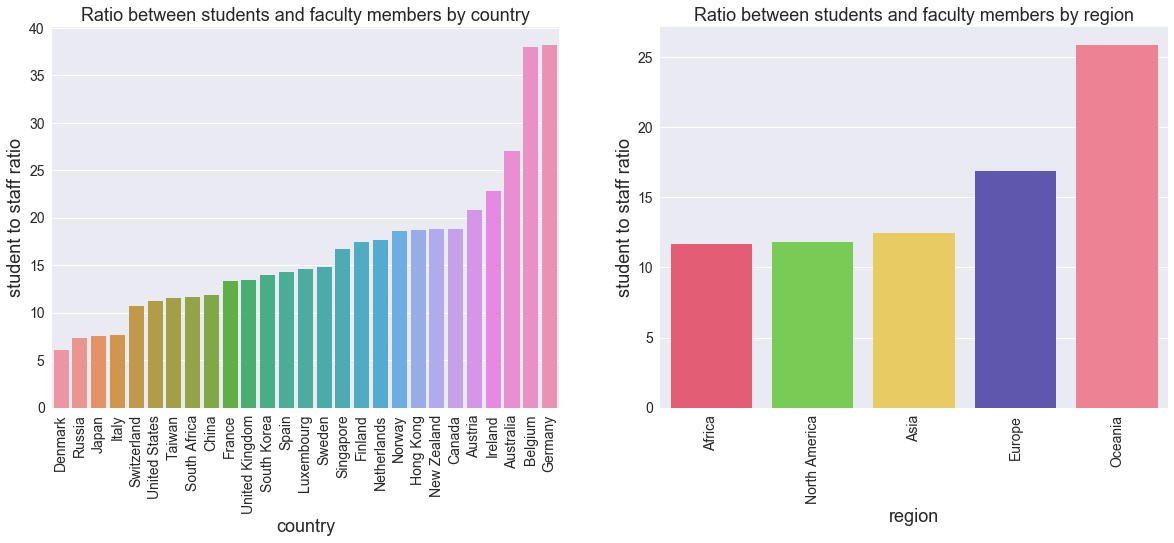

In [44]:
plt.figure(figsize = (20, 7))
grid = GridSpec(1, 2)
#order by ratio between students and faculty members by country
plot_barchart(times_ranking, 'student to staff ratio', 'country', student_staff_ratio, True, grid[0, 0], 'Ratio between students and faculty members by country')
#order by ratio between students and faculty members by region
plot_barchart(times_ranking, 'student to staff ratio', 'region', student_staff_ratio, True, grid[0, 1], 'Ratio between students and faculty members by region')

According to the data from *Times Higher Education* rankings, the country with the best ratio between students and staff is Denmark with the ratio of around 5, and the worst ones are Belgium and Germany with almost 40 students per faculty member. The region with the best ratio between students and staff is Africa, but North America and Asia are closely behind. The worst region by far in this rankings is the Oceania with over 25 students per professor.

We also plotted the graphs for the ratio of international students by country and region.

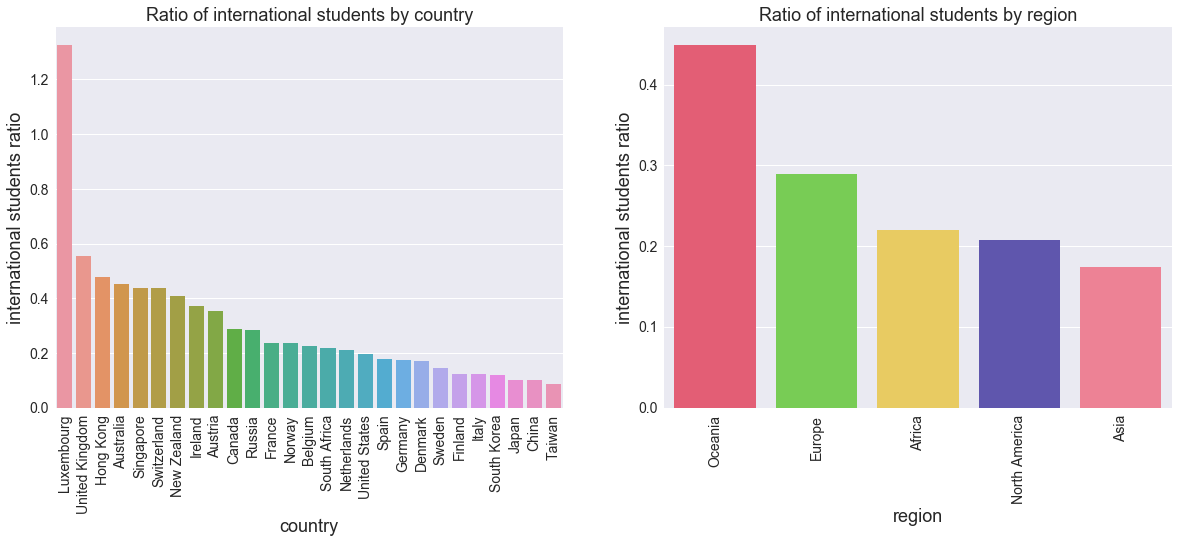

In [45]:
plt.figure(figsize = (20, 7))
grid = GridSpec(1, 2)
#order by ratio of international students by country
plot_barchart(times_ranking, 'international students ratio', 'country', inter_student_ratio, False, grid[0, 0], 'Ratio of international students by country')
#order by ratio of international students by region
plot_barchart(times_ranking, 'international students ratio', 'region', inter_student_ratio, False, grid[0, 1], 'Ratio of international students by region')

The country with the biggest number of international per national students, according to the *Times Higher Education* rankings is Luxembourg. Even though there is a considerable difference between Luxembourg and United Kingdom, which is the second best considering this ratio, the results must be interpreted with some caution, because there is only one university from Luxembourg that was used in the calculations. The region with the best international students ratio is Oceania with ratio of over 0.45, while the worst one is Asia with only under 0.2 international per national students.

### Task 3 - Merging the rankings

To merge the two rankings, we used the *outer* join of *topuni_ranking* DataFrame with the *times_ranking* DataFrame. We dropped the country and region of the *times_ranking* DataFrame because that information is contained in *topuni_ranking* and was based on it.

In [46]:
aggregated = topuni_ranking.join(times_ranking.drop(['country', 'region'], axis = 1), on=None, how='outer', lsuffix=' Top Uni', rsuffix=' Times')
aggregated

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
Aalto University,<10,Finland,370.0,1831.0,=137,Europe,L,public,1257.0,12147.0,9.7,0.2,Aalto University,190,12744.0,2548.8,20.2,630.9,0.2
Aarhus University,>50 and <100,Denmark,602.0,3762.0,119,Europe,L,public,2316.0,26226.0,11.3,0.2,Aarhus University,=109,25167.0,3020.0,14.3,1759.9,0.1
Albert-Ludwigs-Universitaet Freiburg,>100,Germany,413.0,3897.0,171,Europe,L,public,1966.0,23214.0,11.8,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,>100,Italy,153.0,4195.0,=188,Europe,XL,public,2990.0,63399.0,21.2,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Arizona State University,=126,44475.0,8450.2,20.1,2212.7,0.2
Australian National University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australian National University anu,48,15986.0,5595.1,19.3,828.3,0.5
Autonomous University of Barcelona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Autonomous University of Barcelona,=147,32309.0,5169.4,12.9,2504.6,0.2
Boston University,>100,United States,379.0,7041.0,81,North America,L,private,3157.0,25662.0,8.1,0.4,Boston University,=70,24833.0,6208.2,8.6,2887.6,0.3
Brown University,>100,United States,379.0,1825.0,53,North America,M,private,1303.0,9251.0,7.1,0.2,Brown University,=50,8898.0,1779.6,10.7,831.6,0.2
California Institute of Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,California Institute of Technology caltech,=3,2209.0,596.4,6.5,339.8,0.4


In [47]:
aggregated.shape

(295, 19)

We can see that the *aggregated* DataFrame contains 295 entries, some of which are duplicates but were not recognized as such because the joining was done by university name and some of the universities, while the same, have different names in the two ranking DataFrames. Also, some universities exist in one ranking and are not present in the other, so they should not be matched with anything.

In [48]:
aggregated[aggregated['rank Top Uni'].notnull() & aggregated['rank Times'].notnull()].shape

(105, 19)

We can also see that we have successfully merged information about 105 universities...

In [49]:
aggregated[aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull()].shape

(190, 19)

...and that 190 entries failed to match.

We made a copy of the unmatched universities from both rankings in order to process their names and try to merge them.

In [50]:
times_unmatched = aggregated[aggregated['rank Top Uni'].isnull()].copy()
topuni_unmatched = aggregated[aggregated['rank Times'].isnull()].copy()

When a match between university names has been found, the function *match_university()* adds information to the *Top University* entry of the *aggregated* DataFrame using the information from the *Times* entry of the same university.

In [51]:
def match_university(df, topuni_name, times_name):
        df.loc[topuni_name, 'aliases'] = df.loc[times_name, 'aliases']
        df.loc[topuni_name, 'rank Times'] = df.loc[times_name, 'rank Times'] 
        df.loc[topuni_name, 'total students Times'] = df.loc[times_name, 'total students Times']
        df.loc[topuni_name, 'international students Times'] = df.loc[times_name, 'international students Times']      
        df.loc[topuni_name, 'student to staff ratio Times'] = df.loc[times_name, 'student to staff ratio Times']
        df.loc[topuni_name, 'international students ratio Times'] = df.loc[times_name, 'international students ratio Times']
        df.loc[topuni_name, 'total faculty members Times'] = df.loc[times_name, 'total faculty members Times'] 
        df.drop(times_name, inplace = True)

We tried to merge the names of the universities from different rankings by using the *SequenceMatcher* class from the *difflib* library.

*difflib.SequenceMatcher* class works by finding the longest contiguous matching subsequence that contains no “junk” elements; these “junk” elements are ones that are uninteresting in some sense, such as blank lines or whitespace. Here, we empirically established that no "junk" elements are necessary.  *SequenceMatcher.ratio()* just returns a measure of the sequences’ similarity - the higher the similarity - the higher the ratio.

We iterated through each row in *topuni_unmatched* DataFrame and tried to find a *university name* or *alias* from *times_unmatched* DataFrame which has the most similarity with the *university name* from *topuni_unmatched*. If the similarity of two strings was greater than 0.845 (which we empirically confirmed to be the best ratio for these universities), we updated the *aggregated* DataFrame by calling the *match_university()* function. We also dropped this university from the *unmatched* DataFrames in order to speed up the execution of the later loop iterations.

While matching the university names, we noticed that when we drop the parentheses from the university names and aliases we can increase the matching between two universities, thereby increasing the automatization of our work. Also, since some of the university names from *Top University* rankings are in German, we replaced the most common German words with corresponding English ones.

In [52]:
i = 0
for topuni_name, topuni_row in topuni_unmatched.iterrows():
    max_name = None
    max_ratio, old_ratio = 0, 0
    topuni_modified = topuni_name.replace('Universitaet', 'University').replace('Universität', 'University').replace('Technische', 'Technical')
    for times_name, times_row in times_unmatched.iterrows():
        old_ratio = max_ratio
        max_ratio = max(max_ratio,
                        difflib.SequenceMatcher(None, re.sub(r'\([^()]*\)', '', topuni_modified), re.sub(r'\([^()]*\)', '', times_name)).ratio(),
                        difflib.SequenceMatcher(None, re.sub(r'\([^()]*\)', '', topuni_modified), re.sub(r'\([^()]*\)', '', times_row['aliases'])).ratio(),
                        difflib.SequenceMatcher(None, topuni_modified, times_name).ratio(),
                        difflib.SequenceMatcher(None, topuni_modified,times_row['aliases']).ratio())
        if max_ratio > old_ratio:
            max_name = times_name   
    if max_ratio > 0.845:
        i = i + 1
        match_university(aggregated, topuni_name, max_name)
        times_unmatched.drop(max_name, inplace = True)
        topuni_unmatched.drop(topuni_name, inplace = True)
        print(str(i) + ':' + topuni_name + ' --> ' + max_name)

1:California Institute of Technology (Caltech) --> California Institute of Technology
2:ETH Zurich - Swiss Federal Institute of Technology --> ETH Zurich – Swiss Federal Institute of Technology Zurich
3:Ecole Polytechnique --> École Polytechnique
4:Ecole Polytechnique Fédérale de Lausanne (EPFL) --> École Polytechnique Fédérale de Lausanne
5:Freie Universitaet Berlin --> Free University of Berlin
6:Humboldt-Universität zu Berlin --> Humboldt University of Berlin
7:KAIST - Korea Advanced Institute of Science & Technology --> Korea Advanced Institute of Science and Technology (KAIST)
8:KIT, Karlsruhe Institute of Technology --> Karlsruhe Institute of Technology
9:King's College London --> King’s College London
10:London School of Economics and Political Science (LSE) --> London School of Economics and Political Science
11:Massachusetts Institute of Technology (MIT) --> Massachusetts Institute of Technology
12:Nanyang Technological University, Singapore (NTU) --> Nanyang Technological Uni

We can see that using this approach we have succesfuly matched 45 additional universities and that there is 50 more left in each *unmatched* DataFrame. Most of those universities are the ones that appear in one ranking but not another.

In [53]:
topuni_unmatched.shape

(50, 19)

In [54]:
times_unmatched.shape

(50, 19)

In [55]:
aggregated[aggregated['rank Top Uni'].notnull() & aggregated['rank Times'].notnull()].shape

(150, 19)

Afterwards, we manually checked for each region to see whether there are any universities that were unmatched but shouldn't be.

In [56]:
aggregated[(aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull())
           & (aggregated['region'] == 'Europe')]

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
Albert-Ludwigs-Universitaet Freiburg,>100,Germany,413.0,3897.0,171,Europe,L,public,1966.0,23214.0,11.8,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,>100,Italy,153.0,4195.0,=188,Europe,XL,public,2990.0,63399.0,21.2,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CentraleSupélec,>100,France,137.0,1132.0,177,Europe,S,public,529.0,3877.0,7.3,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chalmers University of Technology,>100,Sweden,336.0,1465.0,133,Europe,M,private,1077.0,9257.0,8.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eberhard Karls Universität Tübingen,>100,Germany,796.0,3860.0,=164,Europe,L,public,3844.0,27366.0,7.1,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Ecole normale supérieure, Paris",>100,France,75.0,374.0,43,Europe,S,private,178.0,1907.0,10.7,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ludwig-Maximilians-Universität München,>100,Germany,674.0,5084.0,66,Europe,XL,public,3274.0,35055.0,10.7,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Politecnico di Milano,>100,Italy,231.0,5593.0,170,Europe,XL,public,1500.0,36277.0,24.2,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ruprecht-Karls-Universität Heidelberg,>100,Germany,756.0,5298.0,68,Europe,L,public,3908.0,28852.0,7.4,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento,>25 and <50,Italy,1.0,135.0,=192,Europe,S,public,119.0,789.0,6.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can see that we missed three universities in Europe that exist in both rankings: *Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento*, *Trinity College Dublin, The University of Dublin*, and *Wageningen University*.

In [57]:
#Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento == Scuola Superiore Sant’Anna
match_university(aggregated, 'Scuola Superiore Sant\'Anna Pisa di Studi Universitari e di Perfezionamento', 'Scuola Superiore Sant’Anna')
#Trinity College Dublin == Trinity College Dublin, The University of Dublin
match_university(aggregated, 'Trinity College Dublin, The University of Dublin', 'Trinity College Dublin')
#Wageningen University == Wageningen University & Research
match_university(aggregated, 'Wageningen University', 'Wageningen University & Research')

In [58]:
aggregated.shape

(247, 19)

We can observe that we reduced the number of *aggregated* entries by 3 more, as we expected.

In [59]:
aggregated[(aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull())
           & (aggregated['region'] == 'Asia')]

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
Hanyang University,>50 and <100,South Korea,364.0,3397.0,155,Asia,L,private,3085.0,23348.0,7.6,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hokkaido University,>100,Japan,210.0,1347.0,=122,Asia,L,public,2605.0,17552.0,6.7,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Indian Institute of Science (IISc) Bangalore,>100,India,NaN,47.0,190,Asia,S,public,423.0,4071.0,9.6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Indian Institute of Technology Bombay (IITB),>50 and <100,India,19.0,93.0,=179,Asia,M,public,876.0,9402.0,10.7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Indian Institute of Technology Delhi (IITD),>50 and <100,India,4.0,80.0,172,Asia,M,public,466.0,7477.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Keio University CEMS MIM,>100,Japan,261.0,2178.0,=192,Asia,XL,private,3905.0,33500.0,8.6,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
King Fahd University of Petroleum & Minerals,>50 and <100,Saudi Arabia,665.0,989.0,=173,Asia,M,public,1062.0,6040.0,5.7,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Korea University,>100,South Korea,339.0,3638.0,=90,Asia,L,private,3745.0,25892.0,6.9,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Kyushu University,>100,Japan,246.0,1787.0,128,Asia,L,public,2858.0,18660.0,6.5,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Nagoya University,>100,Japan,206.0,1547.0,=116,Asia,L,public,2665.0,15838.0,5.9,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


By Looking at the unmatched universities in Asia, we can see that all of them are truly different universities, and not in fact the same ones with different names in two rankings.

In [60]:
aggregated[(aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull())
           & (aggregated['region'] == 'Latin America')]

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
Instituto Tecnológico y de Estudios Superiores de Monterrey,>50 and <100,Mexico,821.0,1412.0,199,Latin America,L,private,1822.0,13376.0,7.3,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pontificia Universidad Católica de Chile (UC),>100,Chile,198.0,991.0,=137,Latin America,L,private,2260.0,27003.0,11.9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Universidad Nacional Autónoma de México (UNAM),>100,Mexico,949.0,2173.0,=122,Latin America,XL,public,15073.0,141939.0,9.4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Universidad de Buenos Aires (UBA),>100,Argentina,3165.0,27109.0,75,Latin America,XL,public,16421.0,122301.0,7.4,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Universidad de Chile,>100,Chile,127.0,2134.0,201,Latin America,XL,public,2256.0,38848.0,17.2,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Universidade Estadual de Campinas (Unicamp),>50 and <100,Brazil,109.0,966.0,=182,Latin America,L,public,1968.0,26572.0,13.5,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Universidade de São Paulo,>50 and <100,Brazil,279.0,2086.0,121,Latin America,XL,public,5582.0,65711.0,11.8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The same can be said for Latin America...

In [61]:
aggregated[(aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull())
           & (aggregated['region'] == 'North America')]

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
University of Waterloo,>50 and <100,Canada,473.0,8962.0,152,North America,XL,public,1689.0,35541.0,21.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Université de Montréal,>100,Canada,1037.0,9688.0,130,North America,XL,public,2961.0,39112.0,13.2,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


...North America...

In [62]:
aggregated[(aggregated['rank Top Uni'].isnull() | aggregated['rank Times'].isnull())
           & (aggregated['region'] == 'Oceania')]

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
University of Otago,>100,New Zealand,759.0,3871.0,151,Oceania,L,public,1266.0,18532.0,14.6,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
University of Technology Sydney,>25 and <50,Australia,546.0,7769.0,176,Oceania,L,public,1328.0,24207.0,18.2,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


...and Oceania.

We can now see that we have 153 universities that have been succesfuly matched and appear in both rankings.

In [63]:
aggregated[aggregated['rank Top Uni'].notnull() & aggregated['rank Times'].notnull()].shape

(153, 19)

In [64]:
aggregated = aggregated[aggregated['rank Top Uni'].notnull() & aggregated['rank Times'].notnull()]
aggregated

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
Aalto University,<10,Finland,370.0,1831.0,=137,Europe,L,public,1257.0,12147.0,9.7,0.2,Aalto University,190,12744.0,2548.8,20.2,630.9,0.2
Aarhus University,>50 and <100,Denmark,602.0,3762.0,119,Europe,L,public,2316.0,26226.0,11.3,0.2,Aarhus University,=109,25167.0,3020.0,14.3,1759.9,0.1
Boston University,>100,United States,379.0,7041.0,81,North America,L,private,3157.0,25662.0,8.1,0.4,Boston University,=70,24833.0,6208.2,8.6,2887.6,0.3
Brown University,>100,United States,379.0,1825.0,53,North America,M,private,1303.0,9251.0,7.1,0.2,Brown University,=50,8898.0,1779.6,10.7,831.6,0.2
California Institute of Technology (Caltech),>100,United States,350.0,647.0,4,North America,S,private,953.0,2255.0,2.4,0.4,California Institute of Technology caltech,=3,2209.0,596.4,6.5,339.8,0.4
Cardiff University,>100,United Kingdom,705.0,6090.0,=137,Europe,L,public,2755.0,24565.0,8.9,0.3,Cardiff University,=162,24186.0,6288.4,13.5,1791.6,0.4
Carnegie Mellon University,>100,United States,425.0,6385.0,=47,North America,L,private,1342.0,13356.0,10.0,0.9,Carnegie Mellon University,24,12676.0,5704.2,13.5,939.0,0.8
City University of Hong Kong,>25 and <50,Hong Kong,1027.0,3273.0,49,Asia,M,public,1349.0,9240.0,6.8,0.5,City University of Hong Kong CityU HK City U H...,=119,9240.0,3234.0,11.2,825.0,0.5
Columbia University,>100,United States,913.0,8105.0,18,North America,L,private,6189.0,25045.0,4.0,0.5,Columbia University,14,26587.0,8507.8,6.1,4358.5,0.5
Cornell University,>100,United States,970.0,5411.0,14,North America,L,private,2718.0,21904.0,8.1,0.3,Cornell University,19,21850.0,5244.0,9.8,2229.6,0.3


### Task 4 - Exploratory analysis

### Top Universities rankings

The [QS World University rankings](https://www.topuniversities.com/university-rankings/world-university-rankings/2018) are created using a consistent methodology. Each ranking is calculated with regard to six metrics which are supposed to present the university performance in an objective manner. The methodology of ranking doesn't change often and the results are normalised in order to ensure none of the scientific areas have a favored position.

The six metrics and the percentage of their participation in the final rankings are:
 - Academic reputation **40%**,
 - Employer reputation **10%**,
 - Faculty/student ratio **20%**,
 - Citations per faculty **20%**,
 - International faculty ratio **5%**,
 - International student ratio **5%**.
 
This ranking gives the highest weight to the *academic reputation score*, which is caluclated based on the opinions of around 70 000 experts in the higher education sphere. The *employer reputation* is based on over 30 000 responses in a survey of many important domestic and international employers. For the main indicator of teaching quality this ranking chose *faculty/student ratio* as the main predictor that the students will be able to get meaningful access to lecturers and tutors. The *citations per faculty* metric is used to measure institutional research quality, and it takes into account and normalizes citations of the *Scopus* database, the world’s largest repository of academic journal data for the five-year period before the publishing of the ranking. The *international faculty ratio* and the *international faculty ratio* are used to demonstrate the ability of an institution to attract faculty members and students from abroad and give its students international sympathies and global awareness.

More information about the *Top Universities ranking* methodology can be found [here](https://www.topuniversities.com/qs-world-university-rankings/methodology).

### Times Higher Education rankings

The [Times Higher Education rankings](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats) are created with respect to 13 performance indicators that judge universities based on all of their core missions: teaching, research, knowledge transfer and international outlook.
These performance indicators are grouped into five areas:
 - Teaching (the learning environment),
 - Research (volume, income and reputation),
 - Citations (research influence),
 - International outlook (staff, students and research),
 - Industry income (knowledge transfer).
 
Institutions provide and sign off their institutional data for use in the rankings.

Teaching (the learning environment) indicator counts for **30%** of the final ranking. It consists of following factors:
 - Reputation survey **15%**,
 - Staff-to-student ratio **4.5%**,
 - Doctorate-to-bachelor’s ratio **2.25%**,
 - Doctorates-awarded-to-academic-staff ratio **6%**,
 - Institutional income **2.25%**.

The reputation survey takes into account opinions of over 10 000 experts mixed with results of the survey of the previous year, in order to examine the perceived prestige of institutions in teaching. A high proportion of postgraduate research students is used as a suggestion about the provision of teaching at the highest level. And lastly the institutional income is providing the information about general status of the institution and a broad sense of infrastructure available to the faculty members and students.

Research (volume, income and reputation) indicator counts for **30%** of the final ranking. It consists of following factors:
 - Reputation survey **18%**,
 - Research income **6%**,
 - Research productivity **6%**.
 
The most prominent indicator in this category looks at a university’s reputation for research excellence among its peers based on the responses in the reputation survey. Although the research income can be a controversial indicator it is highly normalized to take into account all of the circumstances that could influence it. To measure productivity of the research the number of papers publsihed is counted and scaled for institutional size and normalised for subject, in order to get a sense of the university's ability to produce papers that are recognizes in quality peer-reviewed journals. 

Citations (research influence) indicator counts for **30%** of the final ranking.

This indicator is used to look at universities’ role in spreading new knowledge and ideas. The citations help to show how much each university is contributing to the sum of human knowledge: they are used to explain whose research has stood out, has been picked up and built on by other scholars and, most importantly, has been shared around the global scholarly community to expand the boundaries of human understanding, irrespective of the discipline.

International outlook (staff, students, research) indicator counts for **7.5%** of the final ranking. It consists of following factors:
 - International-to-domestic-student ratio **2.5%**,
 - International-to-domestic-staff ratio **2.5%**,
 - International collaboration **2.5%**.

The factor that is focused on the international outlook of an university is supposed to present its ability to attract undergraduates, postgraduates and faculty from all over the planet, which can improve its success at the global level.

Industry income (knowledge transfer) indicator counts for **2.5%** of the final ranking.

A university’s ability to help industry with innovations, inventions and consultancy has become a core mission of the contemporary global academy. This category seeks to capture such knowledge-transfer activity by looking at how much research income an institution earns from industry (adjusted for PPP), scaled against the number of academic staff it employs.

More information about the *Times Higher Education ranking* methodology can be found [here](https://www.timeshighereducation.com/world-university-rankings/methodology-world-university-rankings-2018).

### Comparison

By comparing the *Top Universities* and *Times Higher Education* rankings it is obvious that even though they analyze similar indicators they give them very different weights in the final score calculation.

For example here is the percentange that shows how much they value the followig ratios in the final rankings:

|Ratio|Top Universities ranking|Times Higher Education ranking|
|--|-------------------------------||-------------------------------|
|Faculty members to student ratio|20%|4.5%|
|International to national faculty members ratio|5%|2.5%|
|International to national student ratio|5%|2.5%|

These incompatibilities can explain many differences in the final positions of same institutions on the two rankings. Although it can be debated which formula better represents all of the aspects of a successful university it is important to note that both calculations are still improving each year in order to extract and combine as much of the relevant data as possible.

<a id="new_score"></a>
Because of the mentioned inconsistencies between the rankings we wanted to create a separate score that takes into consideration only the ratio between students and faculty members and the ratio of international and national students, as two key factors for the ranking. So, we created the function *create_new_score()* that calculates the new ranking score for each university with the respect to data about number of students per faculty member and number of international per national students collected by both *Top Universities* and *Times Higher Education* rankings.

In [65]:
def create_new_score(row):
    new_ranking= 0.0
    avg_student_staff = 2/(row['student to staff ratio Top Uni'] + row['student to staff ratio Times'])
    avg_inter_stud = (row['international students ratio Top Uni'] + row['international students ratio Times'])/2
    new_ranking = avg_student_staff + avg_inter_stud
    return new_ranking

In [66]:
analysis = aggregated.copy()
analysis['combined score'] = analysis.apply(create_new_score, axis = 1)

We created a helper function *plot_grouped()* to help us plot bar charts. It creates a bar chart (*barplot*) at the desired *grid_position*. The bar chart is made by taking the DataFrame *df*, and grouping by the *groupby_col* and applying the function specified by the *how* parameter to the columns. Then a new column is added, called *new_col* which is filled with values that are made by applying the *how* to the *info_col* column. The values in the *new_col* are then plotted. The subplot title is set with the *title* parameter.

In [67]:
def plot_grouped(df, group_col, info_col, new_col, how, grid_position, title):
    plt.subplot(grid_position)
    if how == 'count':
        kwargs = { new_col : df.groupby(group_col).count()[info_col]}
        chart = df.groupby(group_col).count().assign(**kwargs)
    else :
        if how == 'mean':
            kwargs = { new_col : df.groupby(group_col).mean()[info_col]}
            chart = df.groupby(group_col).mean().assign(**kwargs)
    sns.barplot(x = chart.index, y = chart[new_col]).set_xticklabels(chart.index, rotation=90, fontsize = 14)
    plt.title(title, fontsize = 18)

We used the *plot_grouped()* to plot distribution of universities by *age* and by *size*.

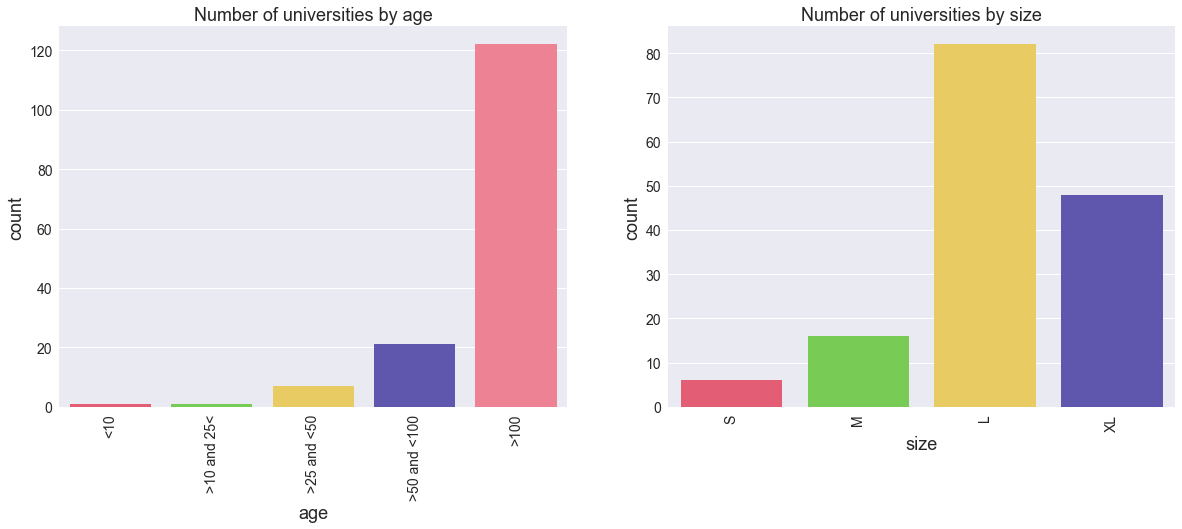

In [68]:
plt.figure(figsize = (20, 7))
grid  = GridSpec(1, 2)
#plot number of universities by age
plot_grouped(analysis, 'age', 'combined score', 'count', 'count', grid[0, 0], 'Number of universities by age')
#plot number of universities by age
plot_grouped(analysis, 'size', 'combined score', 'count', 'count', grid[0, 1], 'Number of universities by size')

As shown above, most universities are over 100 years old, and of size L (more than 12 000 students, but less than 30 000).

We used the *plot_grouped()* to plot the average combined score by *age* and by *size*.

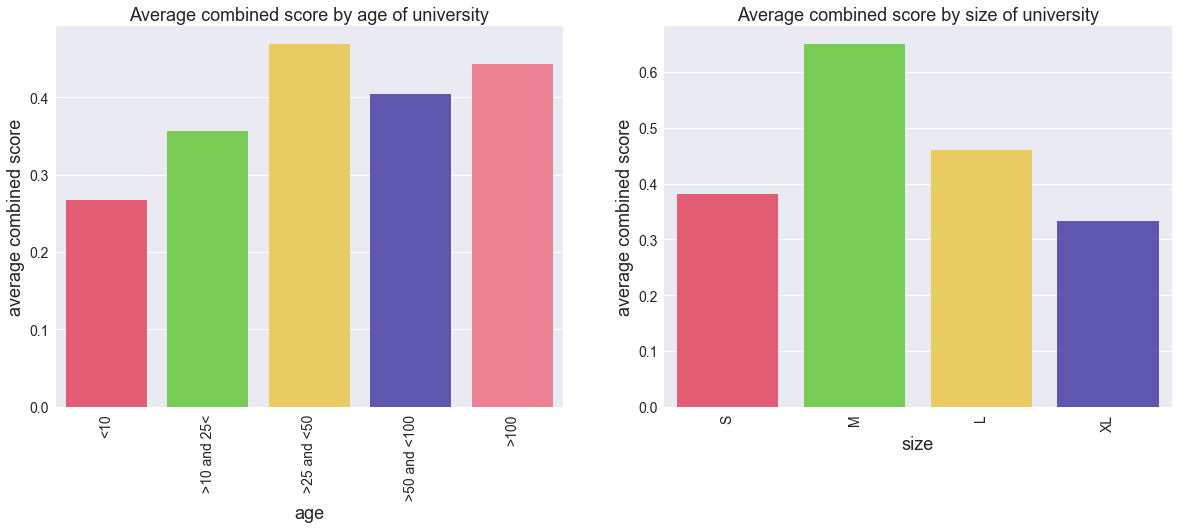

In [69]:
plt.figure(figsize = (20, 7))
grid  = GridSpec(1, 2)
#plot average score by age
plot_grouped(analysis, 'age', 'combined score', 'average combined score', 'mean', grid[0, 0], 'Average combined score by age of university')
#plot average score by size
plot_grouped(analysis, 'size', 'combined score', 'average combined score', 'mean', grid[0, 1], 'Average combined score by size of university')

Here we can see that universities that are in the middle by both size and age score the highest, having the best average combined scores.

Next we wanted to see whether the student to staff ratio differed significantly depending on the size of the university. We averaged the *Top Universities* and *Times* student to staff ratios and then found the distribution of this value over the university sizes. We then plotted this as a bar chart.

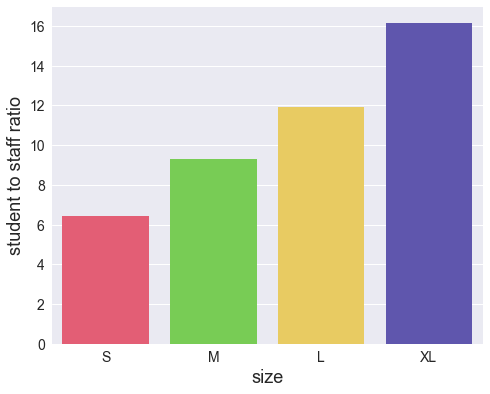

In [70]:
plt.figure(figsize = (17, 6.2))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
student_staff_size_correlation = analysis.filter(['size', 'student to staff ratio Times','student to staff ratio Top Uni'], axis=1)
student_staff_size_correlation['student to staff ratio'] = student_staff_size_correlation.apply( lambda x: (x['student to staff ratio Times'] + x['student to staff ratio Top Uni'])/2, 
                                                             axis = 1)
student_staff_size_correlation = student_staff_size_correlation.filter(['size', 'student to staff ratio'])
student_staff_size_correlation = student_staff_size_correlation.groupby(['size']).mean()
sns.barplot(x = student_staff_size_correlation.index, 
            y = student_staff_size_correlation['student to staff ratio']).set_xticklabels(student_staff_size_correlation.index, fontsize = 14)

As shown above, the ratio grows as the size of the university grows. This may indicate that smaller univeristies could offer a more personalised academic experience.

After this we plotted the average ratio of international students per university size.

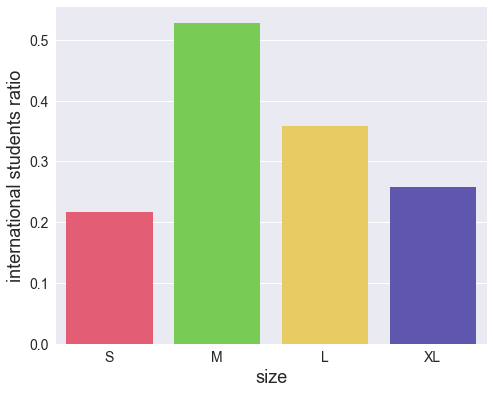

In [71]:
plt.figure(figsize = (17, 6.2))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
inter_students_size_correlation = analysis.filter(['size', 'international students ratio Times','international students ratio Top Uni'], axis=1)
inter_students_size_correlation['international students ratio'] = inter_students_size_correlation.apply( lambda x: (x['international students ratio Times'] + x['international students ratio Top Uni'])/2, 
                                                             axis = 1)
inter_students_size_correlation = inter_students_size_correlation.filter(['size', 'international students ratio'])
inter_students_size_correlation = inter_students_size_correlation.groupby(['size']).mean()
sns.barplot(x = inter_students_size_correlation.index, 
            y = inter_students_size_correlation['international students ratio']).set_xticklabels(inter_students_size_correlation.index, fontsize = 14)

Interestingly, it seems that universities of a medium size have the highest average ratio of international to national students.

After this we plotted the number of public and private universities per country.

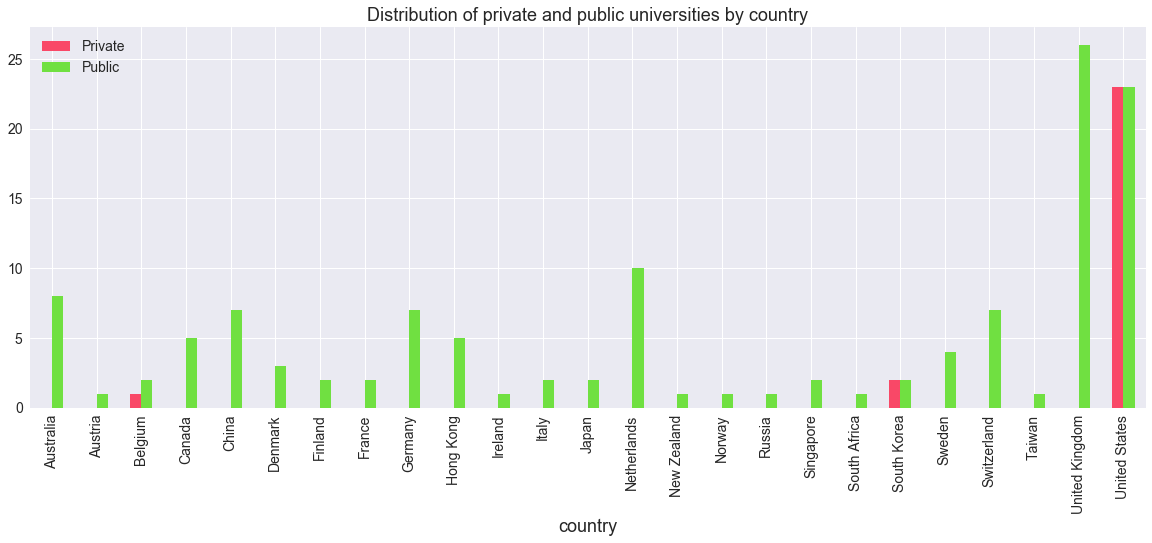

In [72]:
country_status_correlation = analysis.filter(['country', 'status', 'combined score'], axis=1)
country_status_correlation = country_status_correlation.groupby(['country', 'status']).count()
country_status_correlation = country_status_correlation.unstack('status')
country_status_correlation.fillna(0, inplace = True)
graph = country_status_correlation.plot(kind='bar', figsize = (20, 7), fontsize = 14)
graph.legend(['Private', 'Public'], fontsize = 14)
graph.set_title('Distribution of private and public universities by country', fontsize = 18)

Here we can see that only Belgium, South Korea and the United States have private universities. The other countries whose universities qualify to be among the top 200 have public universities. Belgium has one private university and two public, South Korea has two private and public, while the United States also has an equal number of private and public, but here the number of universities in the top 200 is 23. 

Afterwards we decided to look at the average number of students that attend public and private universities. We grouped the universities by status and found the mean of the total students. This number of total students was found by summing the total students detected by the *Top Universities* and *Times* rankings.

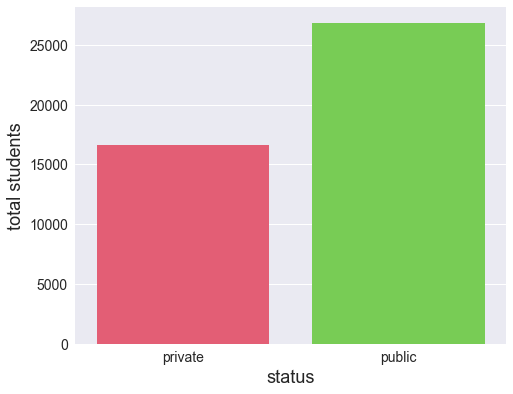

In [73]:
plt.figure(figsize = (17, 6.2))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
total_students_status_correlation = analysis.filter(['status', 'total students Times','total students Top Uni'], axis=1)
total_students_status_correlation['total students'] = total_students_status_correlation.apply( lambda x: (x['total students Times'] + x['total students Top Uni'])/2, 
                                                             axis = 1)
total_students_status_correlation = total_students_status_correlation.filter(['status', 'total students'])
total_students_status_correlation = total_students_status_correlation.groupby(['status']).mean()
sns.barplot(x = total_students_status_correlation.index, 
            y = total_students_status_correlation['total students']).set_xticklabels(total_students_status_correlation.index, fontsize = 14)

By looking at the above bar chart we can see that the average number of students that attend public universities is higher by over 10 000 than those that attend private universities. 

Then we wanted to see whether the status of the university affects the *combined score* of the university. We grouped the universities by status and then found the mean of their combined scores.

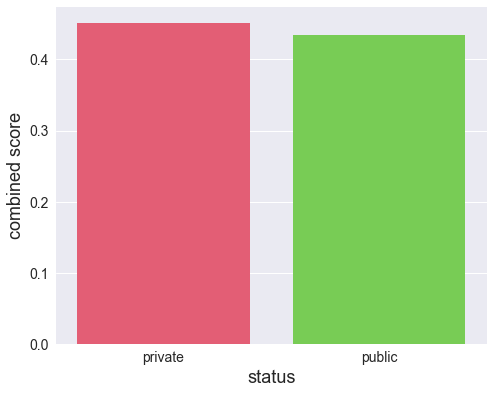

In [74]:
plt.figure(figsize = (17, 6.2))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
status_score_correlation = analysis.filter(['status', 'combined score'], axis=1)
status_score_correlation = status_score_correlation.filter(['status', 'combined score'])
status_score_correlation = status_score_correlation.groupby(['status']).mean()
sns.barplot(x = status_score_correlation.index, 
            y = status_score_correlation['combined score']).set_xticklabels(status_score_correlation.index, fontsize = 14)

We found that the average *combined score* is very similar, regardless of the university status, 0.453403 for private universities and 0.434832 for public.

We can also try to find if there exists a linear dependency between any pair of features in the *aggregated* DataFrame. One of the most elegant ways to check for this is to use the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient).

This can be done using the [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) function.

In [75]:
aggregated.corr(method = 'pearson')

,international faculty members,international students Top Uni,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
international faculty members,1.000000,0.579532,0.646613,0.292953,-0.296369,0.295371,0.290001,0.548943,-0.065695,0.310518,0.249430
international students Top Uni,0.579532,1.000000,0.416946,0.629630,0.273946,0.440132,0.580547,0.926747,0.244918,0.188094,0.349709
total faculty members Top Uni,0.646613,0.416946,1.000000,0.593425,-0.318741,-0.104470,0.610474,0.397652,-0.116183,0.753276,-0.126788
total students Top Uni,0.292953,0.629630,0.593425,1.000000,0.492609,-0.194555,0.982856,0.578742,0.323645,0.527076,-0.244092
student to staff ratio Top Uni,-0.296369,0.273946,-0.318741,0.492609,1.000000,-0.091629,0.456782,0.268330,0.576883,-0.154693,-0.108796
international students ratio Top Uni,0.295371,0.440132,-0.104470,-0.194555,-0.091629,1.000000,-0.220840,0.455719,-0.038507,-0.241595,0.962706
total students Times,0.290001,0.580547,0.610474,0.982856,0.456782,-0.220840,1.000000,0.559712,0.311012,0.556113,-0.261008
international students Times,0.548943,0.926747,0.397652,0.578742,0.268330,0.455719,0.559712,1.000000,0.254958,0.208021,0.431305
student to staff ratio Times,-0.065695,0.244918,-0.116183,0.323645,0.576883,-0.038507,0.311012,0.254958,1.000000,-0.409268,-0.068338
total faculty members Times,0.310518,0.188094,0.753276,0.527076,-0.154693,-0.241595,0.556113,0.208021,-0.409268,1.000000,-0.225817


Here, we have found the Pearson correlation coefficient for every pair of features between the columns of the *aggregated* DataFrame.

It is important to note that while the Pearson correlation for the international students ratio between the two rankings is pretty simmilar (0.962706), the correlation between the student to staff ratio between two rankings is very different (0.576883), which may indicate that the methods of obtaining the information about unversities varies wildly between the analyzed rankings!

We can, for example plot the relation between the total number students and total number of faculty members according to *Top Universities* and *Times* rankings, respectively.

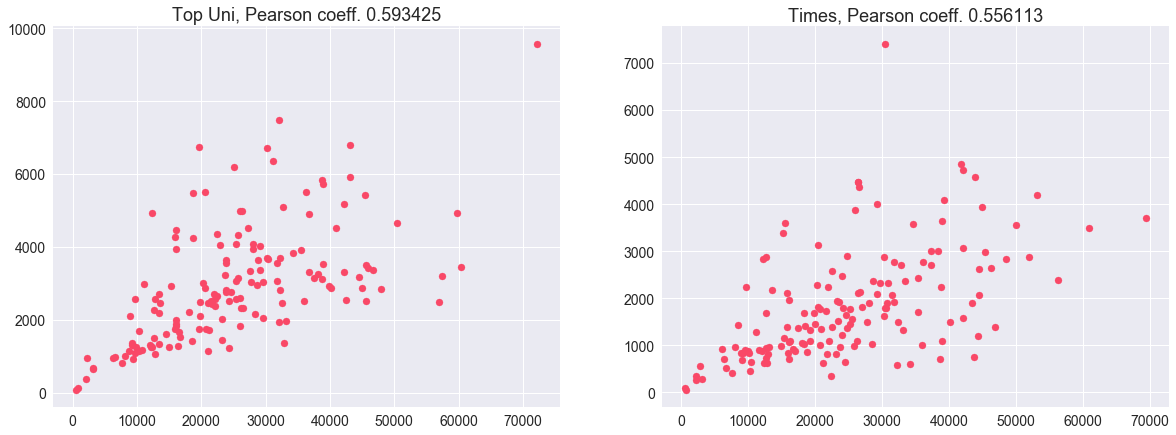

In [76]:
plt.figure(figsize = (20, 7))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
plt.scatter(aggregated['total students Top Uni'], aggregated['total faculty members Top Uni'])
plt.title('Top Uni, Pearson coeff. 0.593425', fontsize = 18)  
plt.subplot(grid[0,1])
plt.scatter(aggregated['total students Times'], aggregated['total faculty members Times'])
plt.title('Times, Pearson coeff. 0.556113', fontsize = 18)  

Here we can observe a slight difference in linearity of the selected features between the differnt rankings.

As suggested in the assignment, we found that the correlation between the number of international students and the number of international faculty members has a Pearson coefficient of 0.579532.

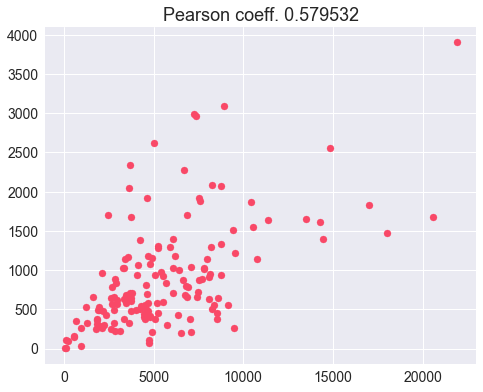

In [77]:
plt.figure(figsize = (17, 6.2))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
plt.scatter(aggregated['international students Top Uni'], aggregated['international faculty members'])
plt.title('Pearson coeff. 0.579532', fontsize = 18)

In the table above we can observe that the Pearson coefficient between the international student ratio and the student to staff ratio for both the *Top Universities* and *Times* rankings have very low values, -0.091629 and -0.068338 respectively. This is also easily detectable in the scatter plots below.

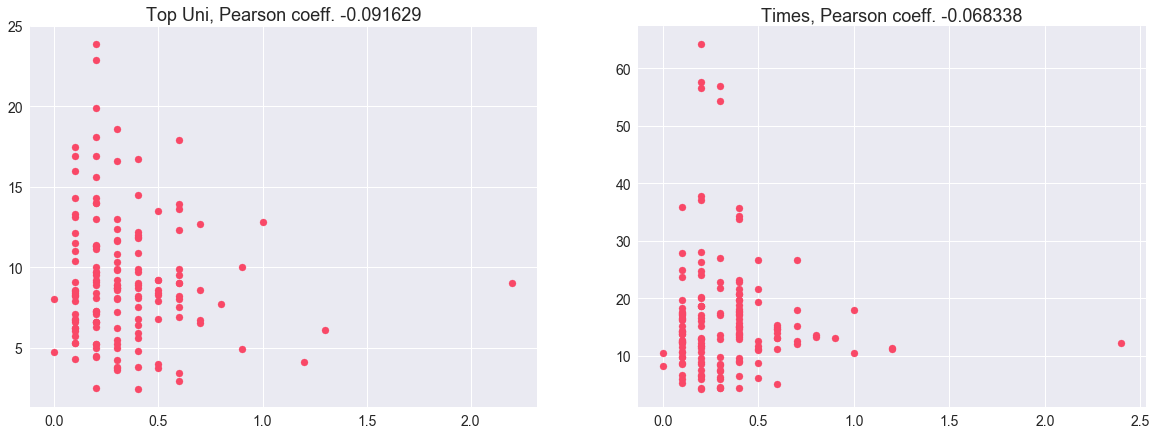

In [78]:
plt.figure(figsize = (20, 7))
grid  = GridSpec(1, 2)
plt.subplot(grid[0,0])
plt.scatter(aggregated['international students ratio Top Uni'], aggregated['student to staff ratio Top Uni'])
plt.title('Top Uni, Pearson coeff. -0.091629', fontsize = 18)  
plt.subplot(grid[0,1])
plt.scatter(aggregated['international students ratio Times'], aggregated['student to staff ratio Times'])
plt.title('Times, Pearson coeff. -0.068338', fontsize = 18)  

We can also try to find if there exists a dependency described using a monotonic (but not necessarily linear) function between any pair of features in the *aggregated* DataFrame. We checked for this using the [Spearman's rank correlation coefficient](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient).

This can also be done using the [pandas.DataFrame.corr](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) function.

In [79]:
aggregated.corr(method = 'spearman')

,international faculty members,international students Top Uni,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
international faculty members,1.000000,0.558903,0.560239,0.262086,-0.243082,0.440969,0.257305,0.543837,0.004097,0.310295,0.392485
international students Top Uni,0.558903,1.000000,0.411711,0.587636,0.299244,0.587849,0.558110,0.956544,0.338820,0.282305,0.507419
total faculty members Top Uni,0.560239,0.411711,1.000000,0.647320,-0.315956,-0.123542,0.645607,0.384710,-0.141981,0.781039,-0.154835
total students Top Uni,0.262086,0.587636,0.647320,1.000000,0.449141,-0.227779,0.989996,0.546897,0.371651,0.597627,-0.280823
student to staff ratio Top Uni,-0.243082,0.299244,-0.315956,0.449141,1.000000,-0.045781,0.441719,0.279443,0.698104,-0.150588,-0.076820
international students ratio Top Uni,0.440969,0.587849,-0.123542,-0.227779,-0.045781,1.000000,-0.255654,0.572067,0.081926,-0.235115,0.923801
total students Times,0.257305,0.558110,0.645607,0.989996,0.441719,-0.255654,1.000000,0.533368,0.361201,0.608337,-0.298162
international students Times,0.543837,0.956544,0.384710,0.546897,0.279443,0.572067,0.533368,1.000000,0.334718,0.255030,0.573462
student to staff ratio Times,0.004097,0.338820,-0.141981,0.371651,0.698104,0.081926,0.361201,0.334718,1.000000,-0.419200,0.026878
total faculty members Times,0.310295,0.282305,0.781039,0.597627,-0.150588,-0.235115,0.608337,0.255030,-0.419200,1.000000,-0.248890


We can check whether the correletion coefficient differ significantly between the two methods that we used by subtracting the generated DataFrames from each other.

In [80]:
difference = aggregated.corr(method = 'spearman') - aggregated.corr(method = 'pearson')
difference

,international faculty members,international students Top Uni,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
international faculty members,0.000000,-0.020629,-0.086374,-0.030867,0.053287,0.145598,-0.032695,-0.005107,0.069791,-0.000223,0.143055
international students Top Uni,-0.020629,0.000000,-0.005235,-0.041994,0.025298,0.147716,-0.022438,0.029797,0.093902,0.094210,0.157709
total faculty members Top Uni,-0.086374,-0.005235,0.000000,0.053894,0.002785,-0.019072,0.035132,-0.012942,-0.025798,0.027763,-0.028046
total students Top Uni,-0.030867,-0.041994,0.053894,0.000000,-0.043467,-0.033224,0.007140,-0.031845,0.048006,0.070551,-0.036731
student to staff ratio Top Uni,0.053287,0.025298,0.002785,-0.043467,0.000000,0.045847,-0.015063,0.011113,0.121221,0.004104,0.031977
international students ratio Top Uni,0.145598,0.147716,-0.019072,-0.033224,0.045847,0.000000,-0.034814,0.116347,0.120433,0.006480,-0.038905
total students Times,-0.032695,-0.022438,0.035132,0.007140,-0.015063,-0.034814,0.000000,-0.026344,0.050189,0.052224,-0.037154
international students Times,-0.005107,0.029797,-0.012942,-0.031845,0.011113,0.116347,-0.026344,0.000000,0.079760,0.047009,0.142157
student to staff ratio Times,0.069791,0.093902,-0.025798,0.048006,0.121221,0.120433,0.050189,0.079760,0.000000,-0.009932,0.095216
total faculty members Times,-0.000223,0.094210,0.027763,0.070551,0.004104,0.006480,0.052224,0.047009,-0.009932,0.000000,-0.023073


By using the *describe()* function we can detect the maximum difference in each column of the *difference* DataFrame.

In [81]:
difference.describe()

,international faculty members,international students Top Uni,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,0.021440,0.041667,-0.005263,-0.003503,0.021555,0.041492,-0.002166,0.031813,0.058435,0.024465,0.036928
std,0.073656,0.070382,0.037529,0.042633,0.042956,0.076459,0.034008,0.058393,0.051324,0.036969,0.081361
min,-0.086374,-0.041994,-0.086374,-0.043467,-0.043467,-0.038905,-0.037154,-0.031845,-0.025798,-0.023073,-0.038905
25%,-0.025748,-0.012932,-0.022435,-0.034977,0.001393,-0.026148,-0.029520,-0.009024,0.024003,-0.000112,-0.032389
50%,-0.000223,0.025298,-0.005235,-0.030867,0.011113,0.006480,-0.015063,0.011113,0.069791,0.006480,0.000000
75%,0.061539,0.094056,0.015274,0.027573,0.038912,0.118390,0.021136,0.063385,0.094559,0.049617,0.118686
max,0.145598,0.157709,0.053894,0.070551,0.121221,0.147716,0.052224,0.142157,0.121221,0.094210,0.157709


The largest difference detected is between the Spearman and Pearson coeffiecients for the *international students Top Uni* and *international students ratio Times* columns. We donot think that this is of particular importance asthese two columns contain completely unrelated data.

### Task 5 - New ranking

Firstly, we tried to sort all of the universities with respect to *Top Universities* and *Times Higher Education* rankings just by finding the average value of the rank of one university in both lists.

In order to create this ranking, we wrote two functions:
- *extract_value()* - that extracts the rank selected university has in a given ranking list,
- *create_new_ranking()* - for each university, this function calculates the mean value of the rankings provided in the *Top Universities* and *Times Higher Education* rankings.

In [82]:
#basic ranking method
def extract_value(rank):
    return int(rank.strip().replace('=', ''))

def create_new_ranking(row):
    times_ranking = extract_value(row['rank Times'])
    top_ranking =  extract_value(row['rank Top Uni'])    
    return times_ranking*0.5 + top_ranking*0.5

We applied the mentioned functions to the newly created *new_ranking* DataFrame (which is just a copy of our *aggregated* DataFrame), and sorted the universities according to the *new ranking* column. According to this new ranking the best university would be the *Stanford University* from United States.

Although this ranking provides an easy solution that takes into consideration both rankings, we feel it might be a bit too naive, because it doesn't take into account the number and weights of the indicators used for calculation of the final scores in each of the rankings.

In [83]:
new_ranking = aggregated.copy()
new_ranking['new ranking'] = new_ranking.apply(create_new_ranking, axis = 1).rank(method = 'min')
new_ranking.sort_values('new ranking')

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,student to staff ratio Top Uni,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times,new ranking
Stanford University,>100,United States,2042.0,3611.0,2,North America,L,private,4285.0,15878.0,3.7,0.3,Stanford University,=3,15845.0,3485.9,7.5,2112.7,0.3,1.0
Massachusetts Institute of Technology (MIT),>100,United States,1679.0,3717.0,1,North America,M,private,2982.0,11067.0,3.7,0.5,Massachusetts Institute of Technology,5,11177.0,3800.2,8.7,1284.7,0.5,2.0
University of Cambridge,>100,United Kingdom,2278.0,6699.0,5,Europe,L,public,5490.0,18770.0,3.4,0.6,University of Cambridge,2,18389.0,6436.1,10.9,1687.1,0.5,3.0
University of Oxford,>100,United Kingdom,2964.0,7353.0,6,Europe,L,public,6750.0,19720.0,2.9,0.6,University of Oxford,1,20409.0,7755.4,11.2,1822.2,0.6,3.0
California Institute of Technology (Caltech),>100,United States,350.0,647.0,4,North America,S,private,953.0,2255.0,2.4,0.4,California Institute of Technology caltech,=3,2209.0,596.4,6.5,339.8,0.4,3.0
Harvard University,>100,United States,1311.0,5266.0,3,North America,L,private,4350.0,22429.0,5.2,0.3,Harvard University,6,20326.0,5284.8,8.9,2283.8,0.4,6.0
Imperial College London,>100,United Kingdom,2071.0,8746.0,8,Europe,L,public,3930.0,16090.0,4.1,1.2,Imperial College London,8,15857.0,8721.4,11.4,1391.0,1.2,7.0
University of Chicago,>100,United States,635.0,3379.0,9,North America,L,private,2449.0,13557.0,5.5,0.3,University of Chicago,9,13525.0,3381.2,6.2,2181.5,0.3,8.0
ETH Zurich - Swiss Federal Institute of Technology,>100,Switzerland,1886.0,7563.0,10,Europe,L,public,2477.0,19815.0,8.0,0.6,ETH Zurich – Swiss Federal Institute of Techno...,=10,19233.0,7308.5,14.6,1317.3,0.6,9.0
Princeton University,>100,United States,246.0,1793.0,13,North America,M,private,1007.0,8069.0,8.0,0.3,Princeton University,7,7955.0,1909.2,8.3,958.4,0.3,9.0


Instead, we feel that one of the possible solutions for the final ranking is the one that takes into consideration just the student to staff ratio and international to national students ratio to create a new ranking. The score that is used for this new ranking was already calculated in a [past step](#new_score), so we can just create a new ranking with respect to it.

In [84]:
analysis['combined rank'] = analysis['combined score'].rank(method = 'min', ascending = False)
analysis.sort_values('combined rank')

,age,country,international faculty members,international students Top Uni,rank Top Uni,region,size,status,total faculty members Top Uni,total students Top Uni,...,international students ratio Top Uni,aliases,rank Times,total students Times,international students Times,student to staff ratio Times,total faculty members Times,international students ratio Times,combined score,combined rank
London School of Economics and Political Science (LSE),>100,United Kingdom,687.0,6748.0,35,Europe,M,public,1088.0,9760.0,...,2.2,London School of Economics and Political Science,=25,10065.0,7146.1,12.2,825.0,2.4,2.394340,1.0
Ecole Polytechnique Fédérale de Lausanne (EPFL),>100,Switzerland,1300.0,5896.0,12,Europe,M,public,1695.0,10343.0,...,1.3,École Polytechnique Fédérale de Lausanne,=38,9928.0,5460.4,11.2,886.4,1.2,1.365607,2.0
Imperial College London,>100,United Kingdom,2071.0,8746.0,8,Europe,L,public,3930.0,16090.0,...,1.2,Imperial College London,8,15857.0,8721.4,11.4,1391.0,1.2,1.329032,3.0
UCL (University College London),>100,United Kingdom,2554.0,14854.0,7,Europe,XL,public,6345.0,31080.0,...,0.9,University College London ucl,16,30304.0,14849.0,10.5,2886.1,1.0,1.079870,4.0
Maastricht University,>25 and <50,Netherlands,502.0,8234.0,200,Europe,L,public,1277.0,16385.0,...,1.0,Maastricht University,103,16727.0,8363.5,18.0,929.3,1.0,1.064935,5.0
University of St Andrews,>100,United Kingdom,485.0,4030.0,92,Europe,M,public,1140.0,8800.0,...,0.8,University of St Andrews,=143,9005.0,4322.4,13.0,692.7,0.9,0.946618,6.0
Carnegie Mellon University,>100,United States,425.0,6385.0,=47,North America,L,private,1342.0,13356.0,...,0.9,Carnegie Mellon University,24,12676.0,5704.2,13.5,939.0,0.8,0.935106,7.0
Queen Mary University of London,>100,United Kingdom,801.0,6806.0,127,Europe,L,public,1885.0,16135.0,...,0.7,Queen Mary University of London,121,15405.0,6932.2,13.3,1158.3,0.8,0.841324,8.0
King's College London,>100,United Kingdom,1513.0,9451.0,=23,Europe,L,public,3650.0,23780.0,...,0.7,King’s College London,36,23207.0,9514.9,12.0,1933.9,0.7,0.808108,9.0
The University of Hong Kong,>100,Hong Kong,2085.0,8230.0,26,Asia,L,public,3012.0,20214.0,...,0.7,University of Hong Kong HKU hku The University...,40,18364.0,7712.9,18.0,1020.2,0.7,0.780972,10.0


This new ranking provides an interesting new view of the list of the best universities, and the best university according to this ranking is the *London School of Economics and Political Science (LSE)*, while the second place belongs to the *Ecole Polytechnique Fédérale de Lausanne (EPFL)*. ^^ <3